# Практическая работа №7. Использование автоэнкодера для решения задач семантической сегментации. Часть 2

[**Ссылка на код с пары**](https://colab.research.google.com/drive/1kcXnm6ZNrjkjUHlkgAIFBmxDd_6lNIHd?usp=sharing)

In [165]:
# Fix error: AttributeError: 'MinMaxScaler' object has no attribute 'min_'
!pip install -U scikit-learn

# Fix 'segmentation_models' compitability
!pip install -q tensorflow==2.10.1

ERROR: Could not install packages due to an OSError: [WinError 5] Отказано в доступе: 'C:\\Users\\flexl\\anaconda3\\envs\\keras\\Lib\\site-packages\\tensorflow\\compiler\\tf2tensorrt\\_pywrap_py_utils.pyd'
Consider using the `--user` option or check the permissions.



## Пример создания модели с Unet-подобной архитектурой

In [ ]:
from tensorflow.keras import Model, Input
from keras.layers import Conv2D, MaxPooling2D, concatenate, UpSampling2D, Dropout, Cropping2D, Softmax, Conv2DTranspose
from keras.preprocessing import image
from keras.utils.vis_utils import plot_model

In [2]:
def mini_u_net(image_shape, num_of_classes):
  
  input_image = Input(image_shape)

  # Encoder
  
  conv1_1 = Conv2D(filters = 32, kernel_size = (3, 3), padding = 'same', activation = 'relu', name = 'conv1_1')(input_image)
  conv1_2 = Conv2D(filters = 32, kernel_size = (3, 3), padding = 'same', activation = 'relu', name = 'conv1_2')(conv1_1)
  
  pool_1 = MaxPooling2D(name = 'pool_1')(conv1_2)
  
  conv2_1 = Conv2D(filters = 64, kernel_size = (3, 3), padding = 'same', activation = 'relu', name = 'conv2_1')(pool_1)
  conv2_2 = Conv2D(filters = 64, kernel_size = (3, 3), padding = 'same', activation = 'relu', name = 'conv2_2')(conv2_1)
  
  pool_2 = MaxPooling2D(name = 'pool_2')(conv2_2)
  
  conv3_1 = Conv2D(filters = 128, kernel_size = (3, 3), padding = 'same', activation = 'relu', name = 'conv3_1')(pool_2)
  conv3_2 = Conv2D(filters = 128, kernel_size = (3, 3), padding = 'same', activation = 'relu', name = 'conv3_2')(conv3_1)
  
  pool_3 = MaxPooling2D(name = 'pool_3')(conv3_2)
  
  conv4_1 = Conv2D(filters = 256, kernel_size = (3, 3), padding = 'same', activation = 'relu', name = 'conv4_1')(pool_3)
  conv4_2 = Conv2D(filters = 256, kernel_size = (3, 3), padding = 'same', activation = 'relu', name = 'conv4_2')(conv4_1)
  
  
  
  # Decoder
  
  upconv5_1 = UpSampling2D(name = 'upconv5_1')(conv4_2)
  upconv5_2 = Conv2D(filters = 128, kernel_size = (2, 2), activation = 'relu', padding = 'same', name = 'upconv5_2')(upconv5_1)
  concat_5 = concatenate([upconv5_2, conv3_2], axis = 3, name = 'concat_5') # Split Connections
  
  conv5_1 = Conv2D(filters = 128, kernel_size = (3, 3), padding = 'same', activation = 'relu', name = 'conv5_1')(concat_5)
  conv5_2 = Conv2D(filters = 128, kernel_size = (3, 3), padding = 'same', activation = 'relu', name = 'conv5_2')(conv5_1)
  
  
  upconv6_1 = UpSampling2D(name = 'upconv6_1')(conv5_2)
  upconv6_2 = Conv2D(filters = 64, kernel_size = (2, 2), activation = 'relu', padding = 'same', name = 'upconv6_2')(upconv6_1)
  concat_6 = concatenate([upconv6_2, conv2_2], axis = 3, name = 'concat_6') # Split Connections
  
  conv6_1 = Conv2D(filters = 64, kernel_size = (3, 3), padding = 'same', activation = 'relu', name = 'conv6_1')(concat_6)
  conv6_2 = Conv2D(filters = 64, kernel_size = (3, 3), padding = 'same', activation = 'relu', name = 'conv6_2')(conv6_1)
  
  upconv7_1 = UpSampling2D(name = 'upconv7_1')(conv6_2)
  upconv7_2 = Conv2D(filters = 32, kernel_size = (2, 2), activation = 'relu', padding = 'same', name = 'upconv7_2')(upconv7_1)
  concat_7 = concatenate([upconv7_2, conv1_2], axis = 3, name = 'concat_7') # Split Connections
  
  conv7_1 = Conv2D(filters = 32, kernel_size = (3, 3), padding = 'same', activation = 'relu', name = 'conv7_1')(concat_7)
  conv7_2 = Conv2D(filters = 32, kernel_size = (3, 3), padding = 'same', activation = 'relu', name = 'conv7_2')(conv7_1)
  
  conv8 = Conv2D(filters = num_of_classes, kernel_size = (1, 1), activation = 'softmax', name = 'conv8')(conv7_2)
  
  model = Model(inputs = input_image, outputs = conv8, name = 'model')
  
  return model

In [3]:
unet_model = mini_u_net(image_shape = [256, 256, 3], num_of_classes = 6)

### Описание и визуализация архитектуры созданной модели

In [4]:
unet_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_1 (Conv2D)                (None, 256, 256, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
conv1_2 (Conv2D)                (None, 256, 256, 32) 9248        conv1_1[0][0]                    
__________________________________________________________________________________________________
pool_1 (MaxPooling2D)           (None, 128, 128, 32) 0           conv1_2[0][0]                    
______________________________________________________________________________________________

In [5]:
unet_model.get_config()

{'name': 'model',
 'layers': [{'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, 256, 256, 3),
    'dtype': 'float32',
    'sparse': False,
    'ragged': False,
    'name': 'input_1'},
   'name': 'input_1',
   'inbound_nodes': []},
  {'class_name': 'Conv2D',
   'config': {'name': 'conv1_1',
    'trainable': True,
    'dtype': 'float32',
    'filters': 32,
    'kernel_size': (3, 3),
    'strides': (1, 1),
    'padding': 'same',
    'data_format': 'channels_last',
    'dilation_rate': (1, 1),
    'groups': 1,
    'activation': 'relu',
    'use_bias': True,
    'kernel_initializer': {'class_name': 'GlorotUniform',
     'config': {'seed': None}},
    'bias_initializer': {'class_name': 'Zeros', 'config': {}},
    'kernel_regularizer': None,
    'bias_regularizer': None,
    'activity_regularizer': None,
    'kernel_constraint': None,
    'bias_constraint': None},
   'name': 'conv1_1',
   'inbound_nodes': [[['input_1', 0, 0, {}]]]},
  {'class_name': 'Conv2D',
   'config':

Для визуализации архитектуры модели используется следующий код:

```
plot_model(
unet_model, to_file='model.png', show_shapes=False, show_dtype=False,
show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96
)
```



In [ ]:
plot_model(unet_model, 
           to_file='model.png', 
           show_shapes=False, 
           show_dtype=False,
           show_layer_names=True,
           rankdir='TB',
           expand_nested=False,
           dpi=96
)

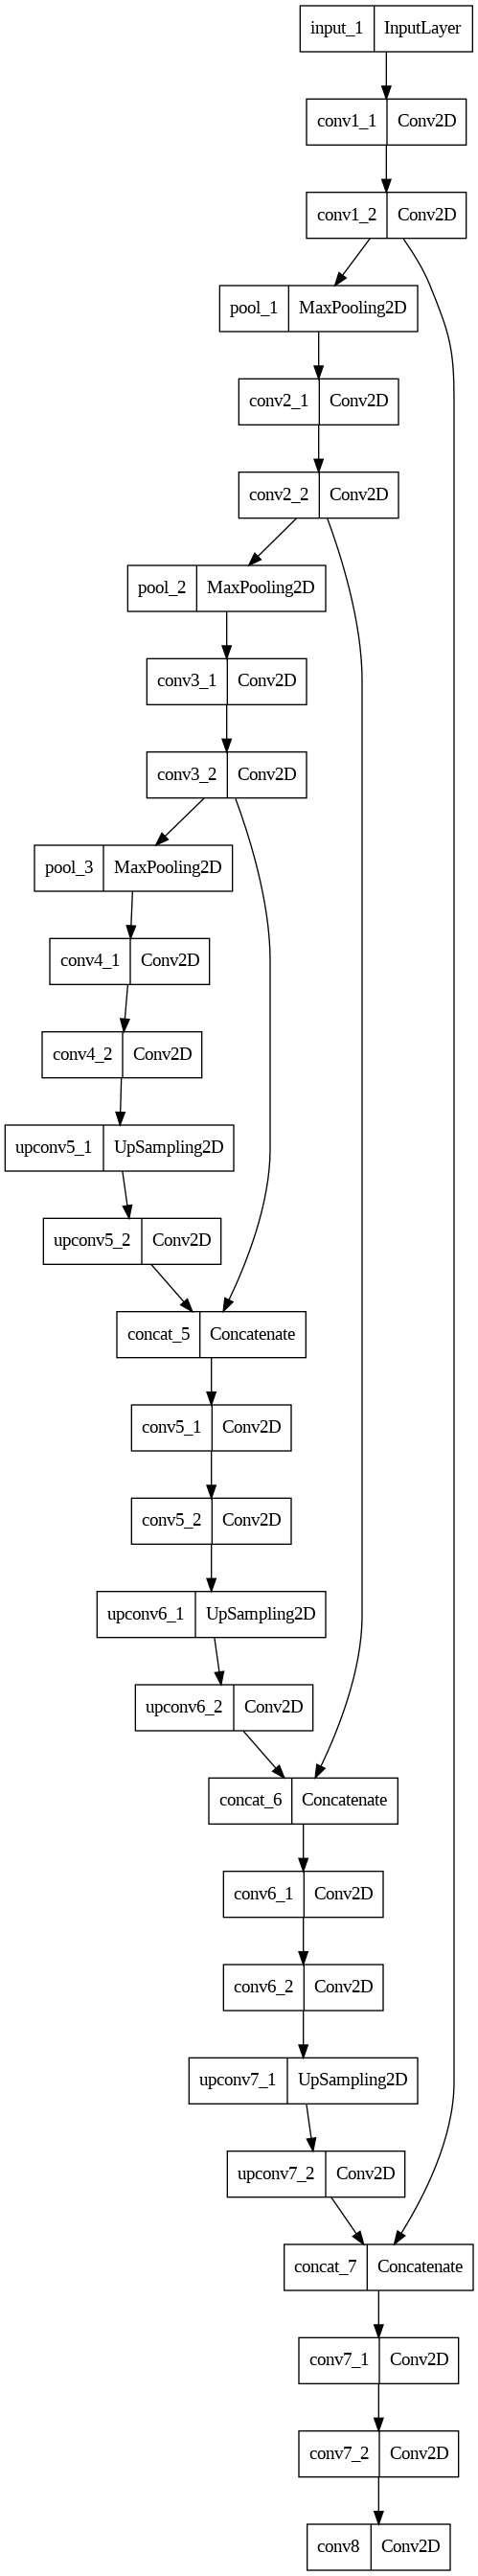

## Задание №1. Создайте модель со следующей архитектурой:

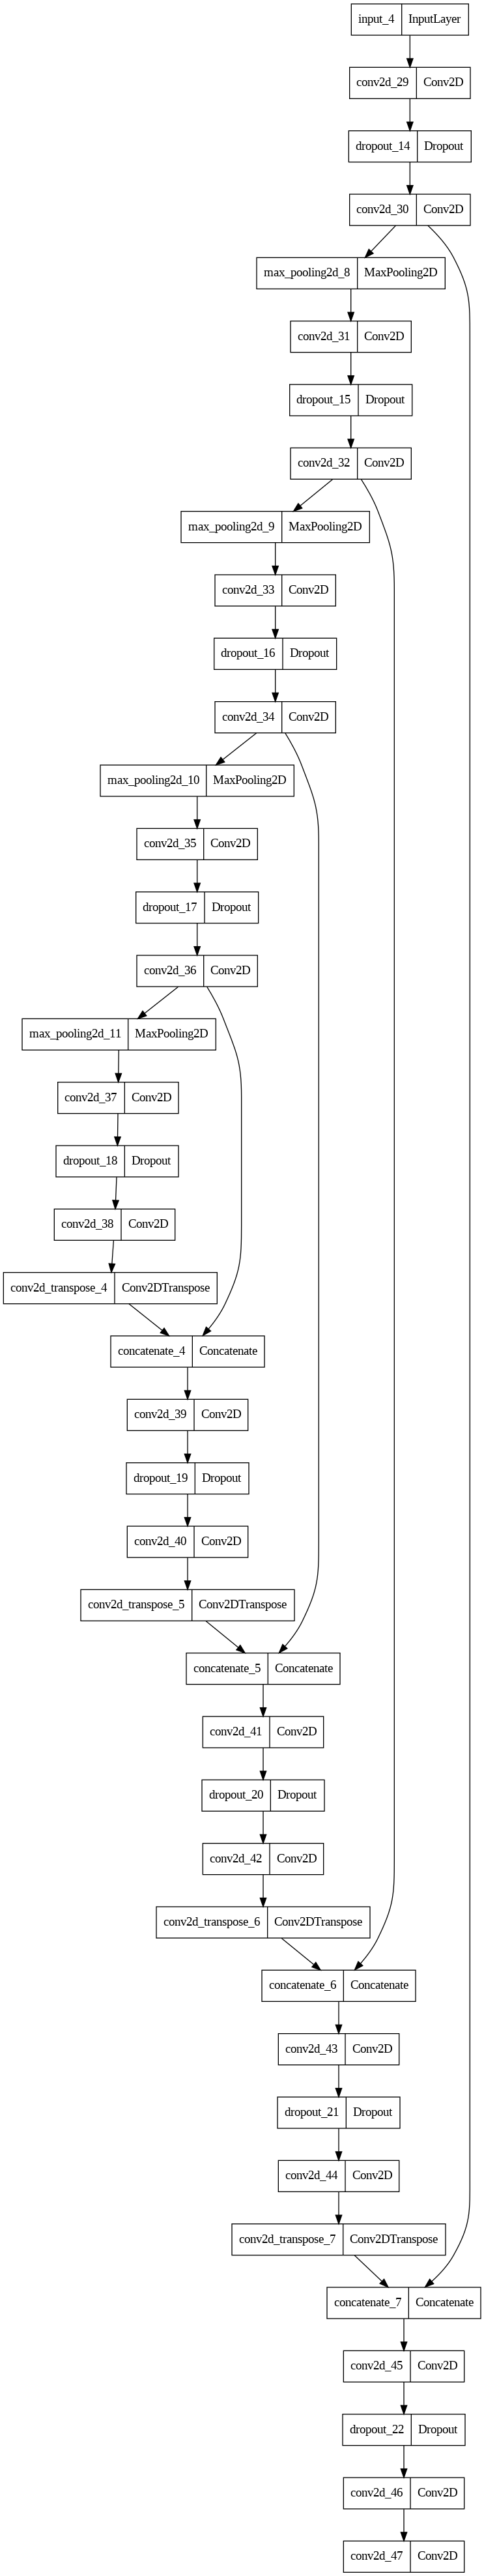

In [ ]:
model_2.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_29 (Conv2D)             (None, 256, 256, 16  448         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 dropout_14 (Dropout)           (None, 256, 256, 16  0           ['conv2d_29[0][0]']              
                                )                                                           

In [ ]:
model_2.get_config()

{'name': 'model_1',
 'trainable': True,
 'layers': [{'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, 256, 256, 3),
    'dtype': 'float32',
    'sparse': False,
    'ragged': False,
    'name': 'input_4'},
   'name': 'input_4',
   'inbound_nodes': []},
  {'class_name': 'Conv2D',
   'config': {'name': 'conv2d_29',
    'trainable': True,
    'dtype': 'float32',
    'filters': 16,
    'kernel_size': (3, 3),
    'strides': (1, 1),
    'padding': 'same',
    'data_format': 'channels_last',
    'dilation_rate': (1, 1),
    'groups': 1,
    'activation': 'relu',
    'use_bias': True,
    'kernel_initializer': {'class_name': 'HeNormal', 'config': {'seed': None}},
    'bias_initializer': {'class_name': 'Zeros', 'config': {}},
    'kernel_regularizer': None,
    'bias_regularizer': None,
    'activity_regularizer': None,
    'kernel_constraint': None,
    'bias_constraint': None},
   'name': 'conv2d_29',
   'inbound_nodes': [[['input_4', 0, 0, {}]]]},
  {'class_name': 'Dropo

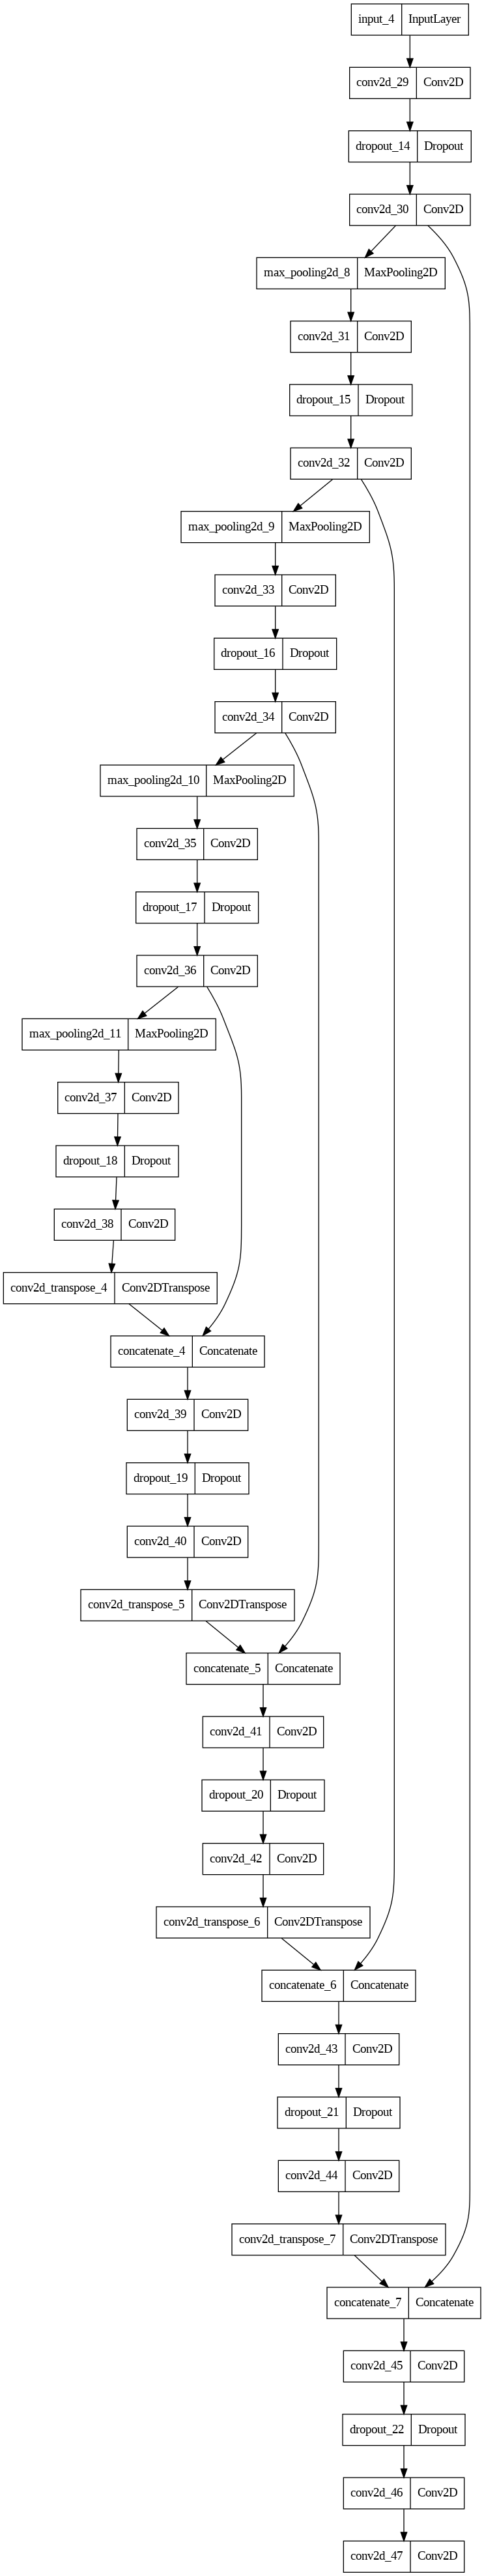

In [ ]:
plot_model(
model_2, to_file='model.png', show_shapes=False, show_dtype=False,
show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96
)

In [1]:
from tensorflow.keras import Model, Input
from keras.layers import Conv2D, MaxPooling2D, concatenate, UpSampling2D, Dropout, Cropping2D, Softmax, Conv2DTranspose
from keras.preprocessing import image
from keras.utils.vis_utils import plot_model

C:\Users\flexl\anaconda3\envs\keras\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\flexl\anaconda3\envs\keras\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
C:\Users\flexl\anaconda3\envs\keras\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
def mini_u_net(image_shape, num_of_classes):
  
    input_image = Input(image_shape)

    # Encoder
    
    conv1_1 = Conv2D(filters = 16, kernel_size = (3, 3), padding = 'same', activation = 'relu', name = 'conv1_1')(input_image)
    dropout1_1 = Dropout(rate=0.2)(conv1_1)
    conv1_2 = Conv2D(filters = 16, kernel_size = (3, 3), padding = 'same', activation = 'relu', name = 'conv1_2')(dropout1_1)

    pool_1 = MaxPooling2D(pool_size=(2,2), name = 'pool_1')(conv1_2)

    conv2_1 = Conv2D(filters = 32, kernel_size = (3, 3), padding = 'same', activation = 'relu', name = 'conv2_1')(pool_1)
    dropout2_1 = Dropout(rate=0.2)(conv2_1)
    conv2_2 = Conv2D(filters = 32, kernel_size = (3, 3), padding = 'same', activation = 'relu', name = 'conv2_2')(dropout2_1)

    pool_2 = MaxPooling2D(pool_size=(2,2), name = 'pool_2')(conv2_2)

    conv3_1 = Conv2D(filters = 64, kernel_size = (3, 3), padding = 'same', activation = 'relu', name = 'conv3_1')(pool_2)
    dropout3_1 = Dropout(rate=0.2)(conv3_1)
    conv3_2 = Conv2D(filters = 64, kernel_size = (3, 3), padding = 'same', activation = 'relu', name = 'conv3_2')(dropout3_1)

    pool_3 = MaxPooling2D(pool_size=(2,2), name = 'pool_3')(conv3_2)

    conv4_1 = Conv2D(filters = 128, kernel_size = (3, 3), padding = 'same', activation = 'relu', name = 'conv4_1')(pool_3)
    dropout4_1 = Dropout(rate=0.2)(conv4_1)
    conv4_2 = Conv2D(filters = 128, kernel_size = (3, 3), padding = 'same', activation = 'relu', name = 'conv4_2')(dropout4_1)


    pool_4 = MaxPooling2D(pool_size=(2,2), name = 'pool_4')(conv4_2)


    conv5_1 = Conv2D(filters = 256, kernel_size = (3, 3), padding = 'same', activation = 'relu', name = 'conv5_1')(pool_4)
    dropout5_1 = Dropout(rate=0.2)(conv5_1)
    conv5_2 = Conv2D(filters = 256, kernel_size = (3, 3), padding = 'same', activation = 'relu', name = 'conv5_2')(dropout5_1)
    
    # Decoder

    upconv5_1 = Conv2DTranspose(filters = 128, kernel_size = (2, 2), strides=(2, 2), activation = 'linear', padding = 'same', name = 'upconv5_1')(conv5_2)

    concat_5 = concatenate([upconv5_1, conv4_2], axis = 3, name = 'concat_5') # Split Connections


    conv6_1 = Conv2D(filters = 128, kernel_size = (3, 3), padding = 'same', activation = 'relu', name = 'conv6_1')(concat_5)
    dropout6_1 = Dropout(rate=0.2)(conv6_1)
    conv6_2 = Conv2D(filters = 128, kernel_size = (3, 3), padding = 'same', activation = 'relu', name = 'conv6_2')(dropout6_1)
    upconv6_1 = Conv2DTranspose(filters = 64, kernel_size = (2, 2), strides=(2, 2), activation = 'linear', padding = 'same', name = 'upconv6_1')(conv6_2)

    concat_6 = concatenate([upconv6_1, conv3_2], axis = 3, name = 'concat_6') # Split Connections

    conv7_1 = Conv2D(filters = 64, kernel_size = (3, 3), padding = 'same', activation = 'relu', name = 'conv7_1')(concat_6)
    dropout7_1 = Dropout(rate=0.2)(conv7_1)
    conv7_2 = Conv2D(filters = 64, kernel_size = (3, 3), padding = 'same', activation = 'relu', name = 'conv7_2')(dropout7_1)
    upconv7_1 = Conv2DTranspose(filters = 32, strides=(2, 2), kernel_size = (2, 2), activation = 'relu', padding = 'same', name = 'upconv7_1')(conv7_2)

    concat_7 = concatenate([upconv7_1, conv2_2], axis = 3, name = 'concat_7') # Split Connections

    conv8_1 = Conv2D(filters = 32, kernel_size = (3, 3), padding = 'same', activation = 'relu', name = 'conv8_1')(concat_7)
    dropout8_1 = Dropout(rate=0.2)(conv8_1)
    conv8_2 = Conv2D(filters = 32, kernel_size = (3, 3), padding = 'same', activation = 'relu', name = 'conv8_2')(dropout8_1)
    upconv8_1 = Conv2DTranspose(filters = 16, strides=(2, 2), kernel_size = (2, 2), activation = 'linear', padding = 'same', name = 'upconv8_1')(conv8_2)

    concat_8 = concatenate([upconv8_1, conv1_2], axis = 3, name = 'concat_8') # Split Connections
    

    conv9_1 = Conv2D(filters = 16, kernel_size = (3, 3), padding = 'same', activation = 'relu', name = 'conv9_1')(concat_8)
    dropout9_1 = Dropout(rate=0.2)(conv9_1)
    conv9_2 = Conv2D(filters = 16, kernel_size = (3, 3), padding = 'same', activation = 'relu', name = 'conv9_2')(dropout9_1)

    conv10 = Conv2D(filters = num_of_classes, kernel_size = (1, 1), activation = 'softmax', name = 'conv10')(conv9_2)

    model = Model(inputs = input_image, outputs = conv10, name = 'model')

    return model

In [24]:
my_unet_model = mini_u_net(image_shape = [256, 256, 3], num_of_classes = 6)

In [49]:
my_unet_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_1 (Conv2D)               (None, 256, 256, 16  448         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 dropout_9 (Dropout)            (None, 256, 256, 16  0           ['conv1_1[0][0]']                
                                )                                                             

                                )                                                                 
                                                                                                  
 conv8_2 (Conv2D)               (None, 128, 128, 32  9248        ['dropout_16[0][0]']             
                                )                                                                 
                                                                                                  
 upconv8_1 (Conv2DTranspose)    (None, 256, 256, 16  2064        ['conv8_2[0][0]']                
                                )                                                                 
                                                                                                  
 concat_8 (Concatenate)         (None, 256, 256, 32  0           ['upconv8_1[0][0]',              
                                )                                 'conv1_2[0][0]']                
          

In [50]:
my_unet_model.get_config()

{'name': 'model',
 'layers': [{'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, 256, 256, 3),
    'dtype': 'float32',
    'sparse': False,
    'ragged': False,
    'name': 'input_2'},
   'name': 'input_2',
   'inbound_nodes': []},
  {'class_name': 'Conv2D',
   'config': {'name': 'conv1_1',
    'trainable': True,
    'dtype': 'float32',
    'filters': 16,
    'kernel_size': (3, 3),
    'strides': (1, 1),
    'padding': 'same',
    'data_format': 'channels_last',
    'dilation_rate': (1, 1),
    'groups': 1,
    'activation': 'relu',
    'use_bias': True,
    'kernel_initializer': {'class_name': 'GlorotUniform',
     'config': {'seed': None}},
    'bias_initializer': {'class_name': 'Zeros', 'config': {}},
    'kernel_regularizer': None,
    'bias_regularizer': None,
    'activity_regularizer': None,
    'kernel_constraint': None,
    'bias_constraint': None},
   'name': 'conv1_1',
   'inbound_nodes': [[['input_2', 0, 0, {}]]]},
  {'class_name': 'Dropout',
   'config'

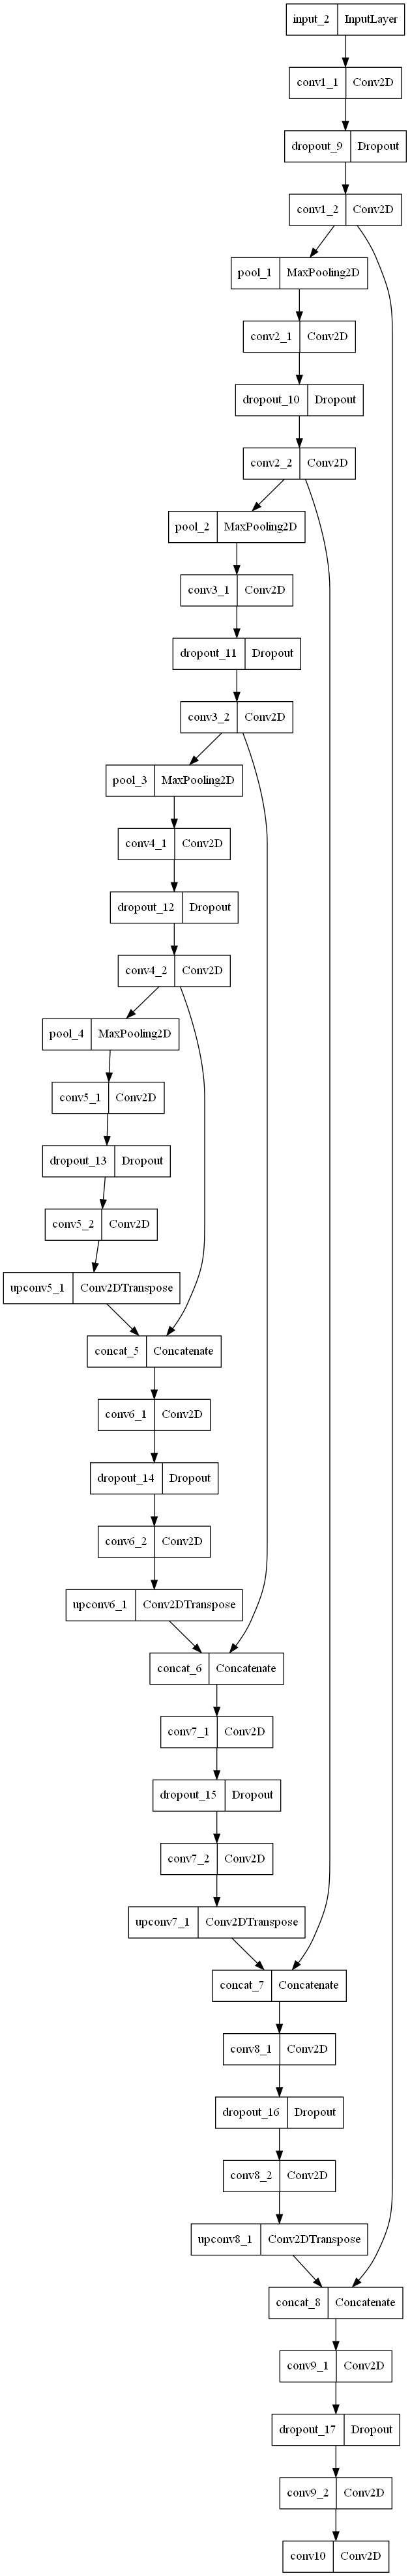

In [51]:
plot_model(my_unet_model, 
           to_file='my_model.png', 
           show_shapes=False, 
           show_dtype=False,
           show_layer_names=True,
           rankdir='TB',
           expand_nested=False,
           dpi=96
)

## Задание №2. Обучите созданную модель для решения задачи семантической сегментации. В качестве функции потерь используйте ту, которая лучше всего показала себя в первой части работы

### 2.0 Обучение спроектированной модели

In [9]:
import cv2
import os
import pickle
import numpy as np
from pathlib import Path
from PIL import Image
from patchify import patchify
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras.utils import to_categorical
from keras.metrics import MeanIoU
import tensorflow as tf

import segmentation_models as sm
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"
from tensorflow.python.client import device_lib

import tensorflow
tensorflow.compat.v1.enable_eager_execution()

import pandas as pd

import plotly.io as pio
import plotly.graph_objects as go
pio.renderers.default = "png"

import sklearn
print(f'Tensorflow version: {tensorflow.__version__}')
print(f'Sklearn version: {sklearn.__version__}')
print(f'Segmentaion models framework: {sm.framework()}')
print(f'Local machine devices: {device_lib.list_local_devices()}')

Segmentation Models: using `keras` framework.
Tensorflow version: 2.10.0
Sklearn version: 1.2.2
Segmentaion models framework: keras
Local machine devices: [name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4804101825823724011
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 5717884928
locality {
  bus_id: 1
  links {
  }
}
incarnation: 7582582980277977739
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3070, pci bus id: 0000:02:00.0, compute capability: 8.6"
xla_global_id: 416903419
]


In [29]:
train_img_dir = 'dataset\\train_image\\train\\'
train_msk_dir = 'dataset\\train_mask\\train\\'

In [30]:
img_paths = sorted(os.listdir(train_img_dir))
msk_paths = sorted(os.listdir(train_msk_dir))

img_count = len(os.listdir(train_img_dir))

In [31]:
Building = np.array((60, 16, 152))
Land = np.array((132, 41, 246))
Road = np.array((110, 193, 228))
Vegetation = np.array((254, 221, 58))
Water = np.array((226, 169, 41))
Unlabeled = np.array((155, 155, 155))

In [32]:
def rgb_to_2D_label(label):
    """
    Преобразовать массив пикселей маски в массив из номеров классов
    """
    if len(label.shape) == 3: 
        label = label[:,:,:3]
    if len(label.shape) == 4: 
        label = label[:,:,:,:3]

    label_seg = np.zeros(label.shape,dtype=np.uint8)
    label_seg[np.all(label == Building,axis=-1)] = 0
    label_seg[np.all(label==Land,axis=-1)] = 1
    label_seg[np.all(label==Road,axis=-1)] = 2
    label_seg[np.all(label==Vegetation,axis=-1)] = 3
    label_seg[np.all(label==Water,axis=-1)] = 4
    label_seg[np.all(label==Unlabeled,axis=-1)] = 5

    if len(label.shape) == 3: 
        label_seg = label_seg[:,:,0]
    if len(label.shape) == 4: 
        label_seg = label_seg[:,:,:,0]
        
    return label_seg

In [38]:
seed=24
batch_size=8
n_classes=6

In [34]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [45]:
from keras.preprocessing.image import ImageDataGenerator

def preprocess_data(img, mask, num_class):
    new_img = scaler.fit_transform(img.reshape(-1, img.shape[-1])).reshape(img.shape)    
    mask = rgb_to_2D_label(mask)
    mask = to_categorical(mask, num_class)
    return (new_img, mask)

def trainGenerator(train_img_path, train_mask_path, num_class):
    img_data_gen_args = dict(horizontal_flip=True,
                      vertical_flip=True)
    
    image_datagen = ImageDataGenerator(**img_data_gen_args)
    mask_datagen = ImageDataGenerator(**img_data_gen_args)
    
    image_generator = image_datagen.flow_from_directory(
        train_img_path,
        class_mode = None,
        batch_size = batch_size,
        seed = seed)
    
    mask_generator = mask_datagen.flow_from_directory(
        train_mask_path,
        class_mode = None,
        batch_size = batch_size,
        seed = seed)
    
    train_generator = zip(image_generator, mask_generator)
    
    for (img, mask) in train_generator:
        img, mask = preprocess_data(img, mask, num_class)
        yield (img, mask)

In [44]:
train_img_path = 'dataset\\train_image\\'
train_msk_path = 'dataset\\train_mask\\'
val_img_path = 'dataset\\val_image\\'
val_msk_path = 'dataset\\val_mask\\'

train_img_gen = trainGenerator(train_img_path, train_msk_path, num_class=6)
val_img_gen = trainGenerator(val_img_path, val_msk_path, num_class=6)

num_train_imgs = len(os.listdir(train_img_path + 'train'))
num_val_images = len(os.listdir(val_img_path + 'val'))

steps_per_epoch = num_train_imgs // batch_size
val_steps_per_epoch = num_val_images // batch_size

print(f'Train generator steps per epoch: {steps_per_epoch}')
print(f'Validation generator steps per epoch: {val_steps_per_epoch}')

Train generator steps per epoch: 51
Validation generator steps per epoch: 17


In [46]:
metrics = ['accuracy', sm.metrics.iou_score, sm.metrics.FScore()]

my_unet_model = mini_u_net(image_shape = [256, 256, 3], num_of_classes = 6)
my_unet_model.compile(optimizer='adam', loss=sm.losses.categorical_focal_dice_loss, metrics=metrics)

In [48]:
from tqdm.keras import TqdmCallback
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, CSVLogger, BackupAndRestore

# Создать директорию для бэкапов модели
backup_dir = 'tmp/backup'
Path(backup_dir).mkdir(parents=True, exist_ok=True)

my_callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=5, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=0, min_lr=0.0001),
    BackupAndRestore(backup_dir),
    CSVLogger("myunet_categorical_focal_dice_loss_history.csv", append=True),
    TqdmCallback(verbose=1),
]

my_unet_history = my_unet_model.fit(
    train_img_gen,
    steps_per_epoch=steps_per_epoch,
    epochs=50,
    verbose=0, 
    validation_steps=val_steps_per_epoch,
    validation_data=val_img_gen,
    callbacks=my_callbacks
)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Found 138 images belonging to 1 classes.
Found 138 images belonging to 1 classes.
Epoch 22: early stopping


In [74]:
def print_stats(history_path, name):
    history = pd.read_csv(history_path)
    fig, axs = plt.subplots(4, 1, sharex=True)
    
    fig.set_figwidth(15)
    fig.set_figheight(15)
    fig.suptitle(name)
    plt.xlabel('Epochs', fontsize=10)
    
    axs[0].set_title("Training and validation loss")
    axs[0].plot(history['loss'])
    axs[0].plot(history['val_loss'])
    axs[0].set_ylabel('Loss')
    axs[0].legend(['Training loss', 'Validation loss'], loc="upper right")

    axs[1].set_title("Training and validation accuracy")
    axs[1].plot(history['accuracy'])
    axs[1].plot(history['val_accuracy'])
    axs[1].set_ylabel('Accuracy')
    axs[1].legend(['Training accuracy', 'Validation accuracy'], loc="lower right")

    axs[2].set_title("Training and validation IOU score")
    axs[2].plot(history['iou_score'])
    axs[2].plot(history['val_iou_score'])
    axs[2].set_ylabel('IOU score')
    axs[2].legend(['Training IOU score', 'Validation IOU score'], loc="lower right")

    axs[3].set_title("Training and validation F1 score")
    axs[3].plot(history['f1-score'])
    axs[3].plot(history['val_f1-score'])
    axs[3].set_ylabel('F1 score')
    axs[3].legend(['Training F1 score', 'Validation F1 score'], loc="lower right")

    fig.subplots_adjust(bottom=0.1, top=0.95)


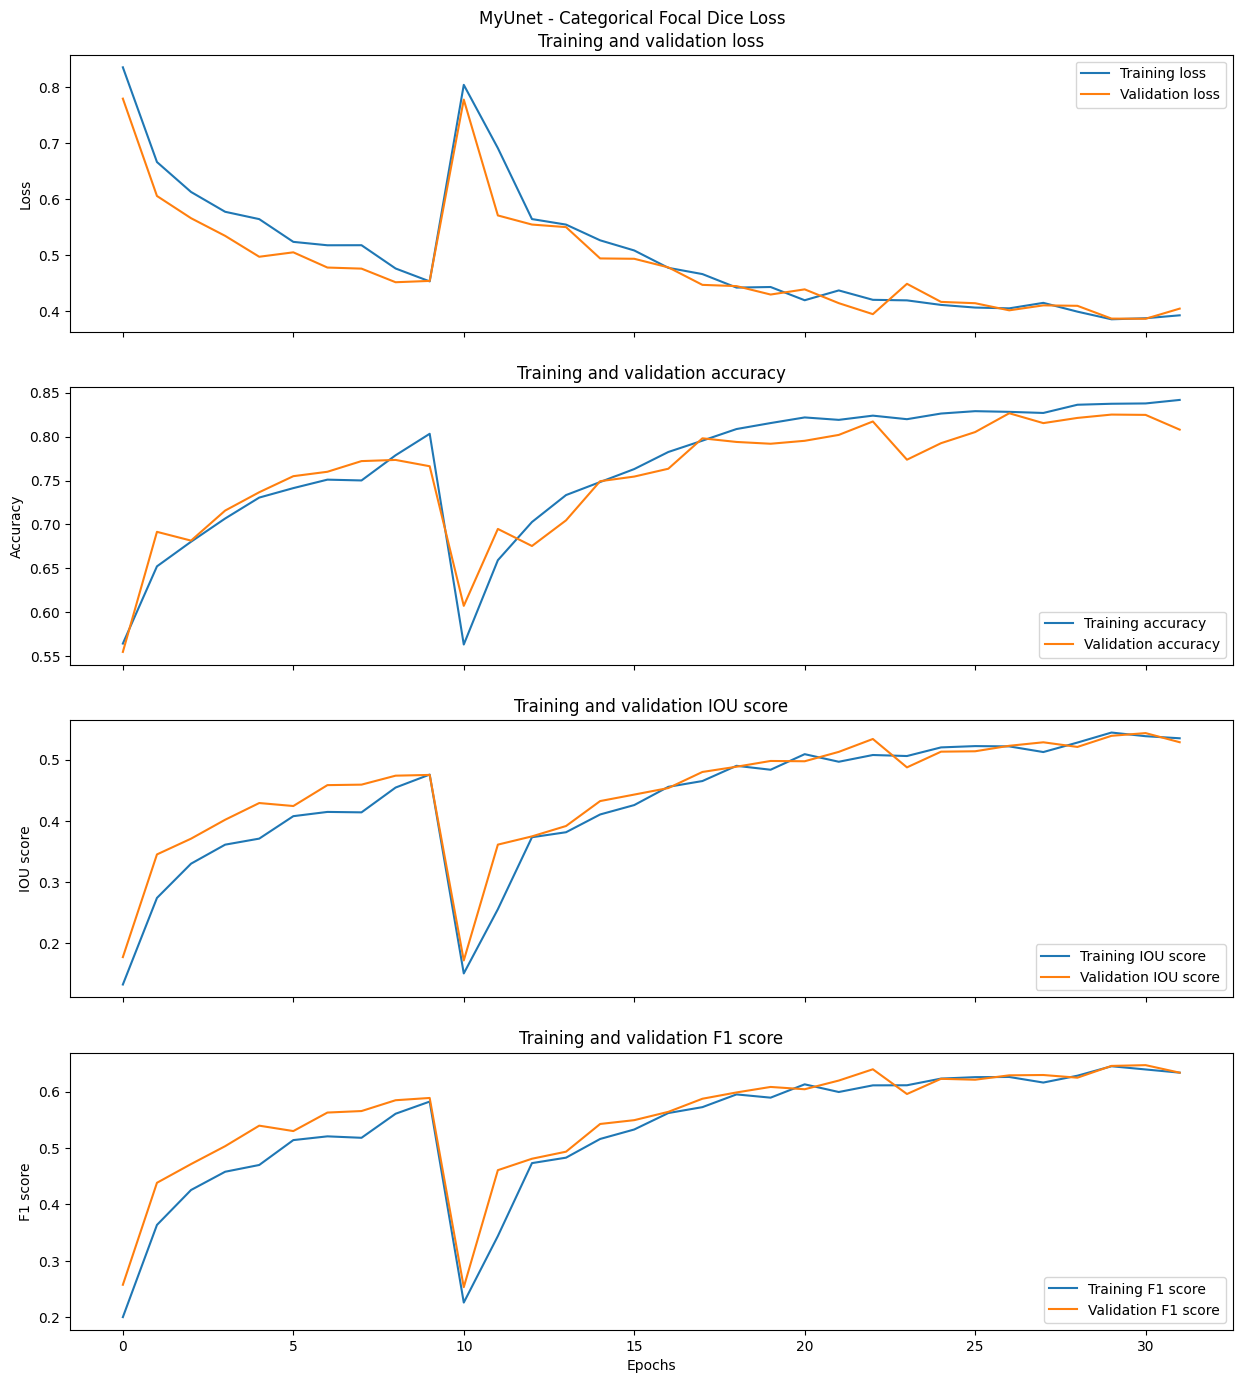

In [53]:
print_stats('myunet_categorical_focal_dice_loss_history.csv', 'MyUnet - Categorical Focal Dice Loss')

In [56]:
my_unet_model.save('myunet_categorical_focal_dice_loss.h5', save_format='h5')

Found 138 images belonging to 1 classes.
Found 138 images belonging to 1 classes.
1/1 [==============================] - 0s 283ms/step


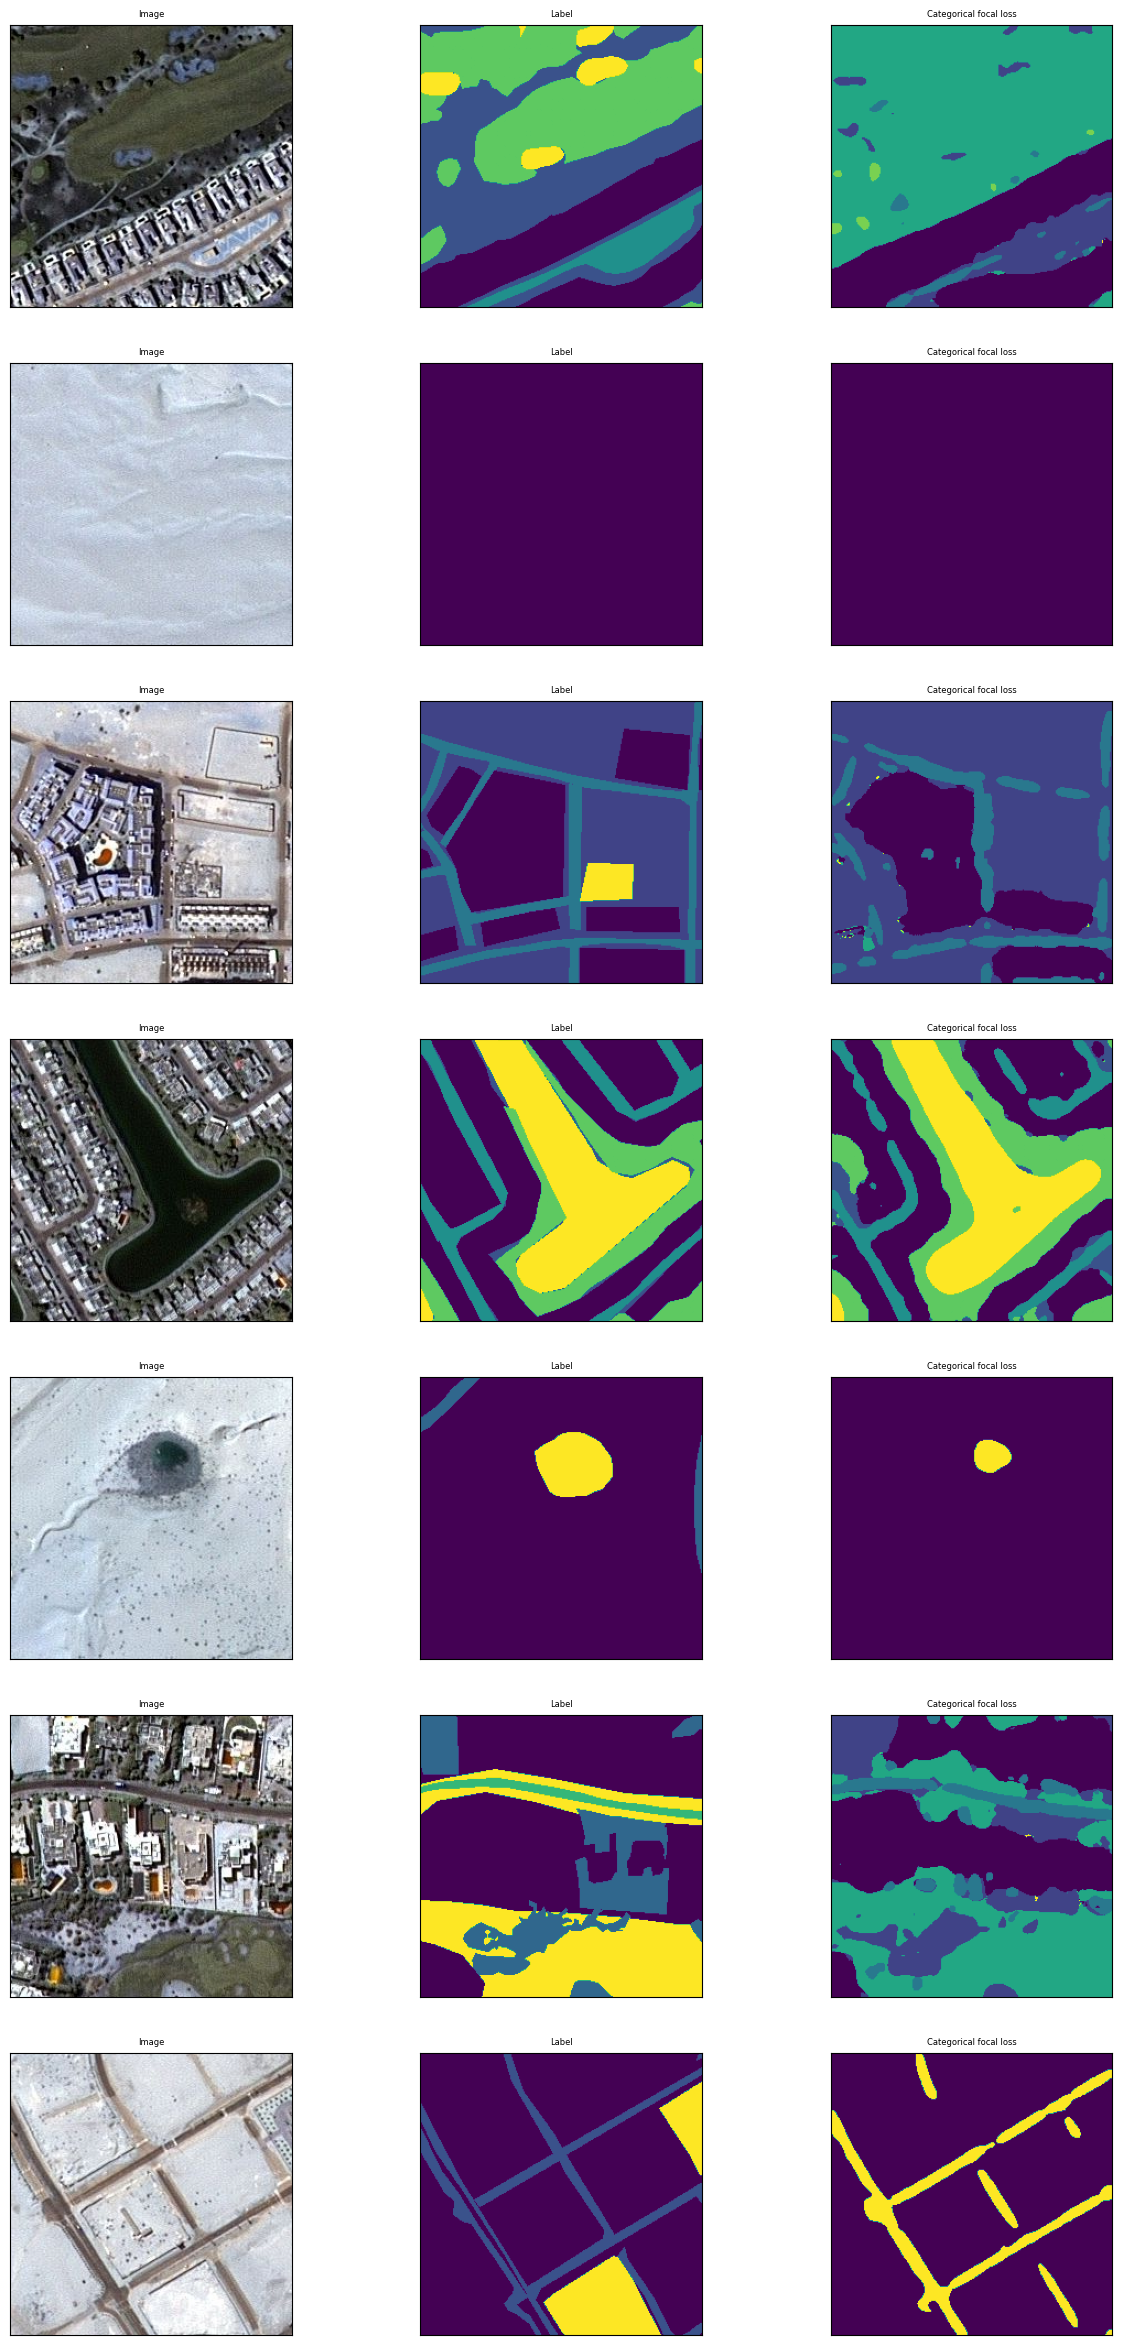

In [57]:
from keras import models

models = [
    models.load_model('myunet_categorical_focal_dice_loss.h5', compile=False)
]

val_img_gen = trainGenerator(val_img_path, val_msk_path, num_class=6)
image_batch, mask_batch = next(val_img_gen)
mask_batch = np.argmax(mask_batch, axis=3)

predictions = [np.argmax(model.predict(image_batch), axis=3) for model in models]

image_count = image_batch.shape[0] - 1

# 6 - оригинал + маска + 4 предсказания
fig, axis = plt.subplots(image_count, 3)
fig.set_figwidth(15)
fig.set_figheight(30)

for i in range(image_count):
    axis[i][0].imshow(image_batch[i])
    axis[i][0].set_title('Image', fontsize = 6)
    axis[i][0].axes.xaxis.set_visible(False)
    axis[i][0].axes.yaxis.set_visible(False)

    axis[i][1].imshow(mask_batch[i])
    axis[i][1].set_title("Label", fontsize = 6)
    axis[i][1].axes.xaxis.set_visible(False)
    axis[i][1].axes.yaxis.set_visible(False)

    axis[i][2].imshow(predictions[0][i])
    axis[i][2].set_title("Categorical focal loss", fontsize = 6)
    axis[i][2].axes.xaxis.set_visible(False)
    axis[i][2].axes.yaxis.set_visible(False)

plt.show()

### 2.1. Загрузите три снимка, а также маски, соответствующие этим снимкам, из папки Tiles 8

In [59]:
"""

Original code is from the following source. It comes with MIT License so please mention
the original reference when sharing.

The original code has been modified to fix a couple of bugs and chunks of code
unnecessary for smooth tiling are removed. 

# MIT License
# Copyright (c) 2017 Vooban Inc.
# Coded by: Guillaume Chevalier
# Source to original code and license:
#     https://github.com/Vooban/Smoothly-Blend-Image-Patches
#     https://github.com/Vooban/Smoothly-Blend-Image-Patches/blob/master/LICENSE

"""
"""Perform smooth predictions on an image from tiled prediction patches."""


import numpy as np
import scipy.signal
from tqdm import tqdm

import gc


if __name__ == '__main__':
    import matplotlib.pyplot as plt
    PLOT_PROGRESS = False
    # See end of file for the rest of the __main__.
else:
    PLOT_PROGRESS = False


def _spline_window(window_size, power=2):
    """
    Squared spline (power=2) window function:
    https://www.wolframalpha.com/input/?i=y%3Dx**2,+y%3D-(x-2)**2+%2B2,+y%3D(x-4)**2,+from+y+%3D+0+to+2
    """
    intersection = int(window_size/4)
    wind_outer = (abs(2*(scipy.signal.triang(window_size))) ** power)/2
    wind_outer[intersection:-intersection] = 0

    wind_inner = 1 - (abs(2*(scipy.signal.triang(window_size) - 1)) ** power)/2
    wind_inner[:intersection] = 0
    wind_inner[-intersection:] = 0

    wind = wind_inner + wind_outer
    wind = wind / np.average(wind)
    return wind


cached_2d_windows = dict()
def _window_2D(window_size, power=2):
    """
    Make a 1D window function, then infer and return a 2D window function.
    Done with an augmentation, and self multiplication with its transpose.
    Could be generalized to more dimensions.
    """
    # Memoization
    global cached_2d_windows
    key = "{}_{}".format(window_size, power)
    if key in cached_2d_windows:
        wind = cached_2d_windows[key]
    else:
        wind = _spline_window(window_size, power)
        wind = np.expand_dims(np.expand_dims(wind, 1), 1)      #SREENI: Changed from 3, 3, to 1, 1 
        wind = wind * wind.transpose(1, 0, 2)
        if PLOT_PROGRESS:
            # For demo purpose, let's look once at the window:
            plt.imshow(wind[:, :, 0], cmap="viridis")
            plt.title("2D Windowing Function for a Smooth Blending of "
                      "Overlapping Patches")
            plt.show()
        cached_2d_windows[key] = wind
    return wind


def _pad_img(img, window_size, subdivisions):
    """
    Add borders to img for a "valid" border pattern according to "window_size" and
    "subdivisions".
    Image is an np array of shape (x, y, nb_channels).
    """
    aug = int(round(window_size * (1 - 1.0/subdivisions)))
    more_borders = ((aug, aug), (aug, aug), (0, 0))
    ret = np.pad(img, pad_width=more_borders, mode='reflect')
    # gc.collect()

    if PLOT_PROGRESS:
        # For demo purpose, let's look once at the window:
        plt.imshow(ret)
        plt.title("Padded Image for Using Tiled Prediction Patches\n"
                  "(notice the reflection effect on the padded borders)")
        plt.show()
    return ret


def _unpad_img(padded_img, window_size, subdivisions):
    """
    Undo what's done in the `_pad_img` function.
    Image is an np array of shape (x, y, nb_channels).
    """
    aug = int(round(window_size * (1 - 1.0/subdivisions)))
    ret = padded_img[
        aug:-aug,
        aug:-aug,
        :
    ]
    # gc.collect()
    return ret


def _rotate_mirror_do(im):
    """
    Duplicate an np array (image) of shape (x, y, nb_channels) 8 times, in order
    to have all the possible rotations and mirrors of that image that fits the
    possible 90 degrees rotations.
    It is the D_4 (D4) Dihedral group:
    https://en.wikipedia.org/wiki/Dihedral_group
    """
    mirrs = []
    mirrs.append(np.array(im))
    mirrs.append(np.rot90(np.array(im), axes=(0, 1), k=1))
    mirrs.append(np.rot90(np.array(im), axes=(0, 1), k=2))
    mirrs.append(np.rot90(np.array(im), axes=(0, 1), k=3))
    im = np.array(im)[:, ::-1]
    mirrs.append(np.array(im))
    mirrs.append(np.rot90(np.array(im), axes=(0, 1), k=1))
    mirrs.append(np.rot90(np.array(im), axes=(0, 1), k=2))
    mirrs.append(np.rot90(np.array(im), axes=(0, 1), k=3))
    return mirrs


def _rotate_mirror_undo(im_mirrs):
    """
    merges a list of 8 np arrays (images) of shape (x, y, nb_channels) generated
    from the `_rotate_mirror_do` function. Each images might have changed and
    merging them implies to rotated them back in order and average things out.
    It is the D_4 (D4) Dihedral group:
    https://en.wikipedia.org/wiki/Dihedral_group
    """
    origs = []
    origs.append(np.array(im_mirrs[0]))
    origs.append(np.rot90(np.array(im_mirrs[1]), axes=(0, 1), k=3))
    origs.append(np.rot90(np.array(im_mirrs[2]), axes=(0, 1), k=2))
    origs.append(np.rot90(np.array(im_mirrs[3]), axes=(0, 1), k=1))
    origs.append(np.array(im_mirrs[4])[:, ::-1])
    origs.append(np.rot90(np.array(im_mirrs[5]), axes=(0, 1), k=3)[:, ::-1])
    origs.append(np.rot90(np.array(im_mirrs[6]), axes=(0, 1), k=2)[:, ::-1])
    origs.append(np.rot90(np.array(im_mirrs[7]), axes=(0, 1), k=1)[:, ::-1])
    return np.mean(origs, axis=0)


def _windowed_subdivs(padded_img, window_size, subdivisions, nb_classes, pred_func):
    """
    Create tiled overlapping patches.
    Returns:
        5D numpy array of shape = (
            nb_patches_along_X,
            nb_patches_along_Y,
            patches_resolution_along_X,
            patches_resolution_along_Y,
            nb_output_channels
        )
    Note:
        patches_resolution_along_X == patches_resolution_along_Y == window_size
    """
    WINDOW_SPLINE_2D = _window_2D(window_size=window_size, power=2)

    step = int(window_size/subdivisions)
    padx_len = padded_img.shape[0]
    pady_len = padded_img.shape[1]
    subdivs = []

    for i in range(0, padx_len-window_size+1, step):
        subdivs.append([])
        for j in range(0, pady_len-window_size+1, step):            #SREENI: Changed padx to pady (Bug in original code)
            patch = padded_img[i:i+window_size, j:j+window_size, :]
            subdivs[-1].append(patch)

    # Here, `gc.collect()` clears RAM between operations.
    # It should run faster if they are removed, if enough memory is available.
    gc.collect()
    subdivs = np.array(subdivs)
    gc.collect()
    a, b, c, d, e = subdivs.shape
    subdivs = subdivs.reshape(a * b, c, d, e)
    gc.collect()

    subdivs = pred_func(subdivs)
    gc.collect()
    subdivs = np.array([patch * WINDOW_SPLINE_2D for patch in subdivs])
    gc.collect()

    # Such 5D array:
    subdivs = subdivs.reshape(a, b, c, d, nb_classes)
    gc.collect()

    return subdivs


def _recreate_from_subdivs(subdivs, window_size, subdivisions, padded_out_shape):
    """
    Merge tiled overlapping patches smoothly.
    """
    step = int(window_size/subdivisions)
    padx_len = padded_out_shape[0]
    pady_len = padded_out_shape[1]

    y = np.zeros(padded_out_shape)

    a = 0
    for i in range(0, padx_len-window_size+1, step):
        b = 0
        for j in range(0, pady_len-window_size+1, step):                #SREENI: Changed padx to pady (Bug in original code)
            windowed_patch = subdivs[a, b]
            y[i:i+window_size, j:j+window_size] = y[i:i+window_size, j:j+window_size] + windowed_patch
            b += 1
        a += 1
    return y / (subdivisions ** 2)


def predict_img_with_smooth_windowing(input_img, window_size, subdivisions, nb_classes, pred_func):
    """
    Apply the `pred_func` function to square patches of the image, and overlap
    the predictions to merge them smoothly.
    See 6th, 7th and 8th idea here:
    http://blog.kaggle.com/2017/05/09/dstl-satellite-imagery-competition-3rd-place-winners-interview-vladimir-sergey/
    """
    pad = _pad_img(input_img, window_size, subdivisions)
    pads = _rotate_mirror_do(pad)

    # Note that the implementation could be more memory-efficient by merging
    # the behavior of `_windowed_subdivs` and `_recreate_from_subdivs` into
    # one loop doing in-place assignments to the new image matrix, rather than
    # using a temporary 5D array.

    # It would also be possible to allow different (and impure) window functions
    # that might not tile well. Adding their weighting to another matrix could
    # be done to later normalize the predictions correctly by dividing the whole
    # reconstructed thing by this matrix of weightings - to normalize things
    # back from an impure windowing function that would have badly weighted
    # windows.

    # For example, since the U-net of Kaggle's DSTL satellite imagery feature
    # prediction challenge's 3rd place winners use a different window size for
    # the input and output of the neural net's patches predictions, it would be
    # possible to fake a full-size window which would in fact just have a narrow
    # non-zero dommain. This may require to augment the `subdivisions` argument
    # to 4 rather than 2.

    res = []
    for pad in tqdm(pads):
        # For every rotation:
        sd = _windowed_subdivs(pad, window_size, subdivisions, nb_classes, pred_func)
        one_padded_result = _recreate_from_subdivs(
            sd, window_size, subdivisions,
            padded_out_shape=list(pad.shape[:-1])+[nb_classes])

        res.append(one_padded_result)

    # Merge after rotations:
    padded_results = _rotate_mirror_undo(res)

    prd = _unpad_img(padded_results, window_size, subdivisions)

    prd = prd[:input_img.shape[0], :input_img.shape[1], :]

    if PLOT_PROGRESS:
        plt.imshow(prd)
        plt.title("Smoothly Merged Patches that were Tiled Tighter")
        plt.show()
    return prd

In [60]:
test_img_dir = 'Semantic segmentation dataset\\Tile 8\\images'
test_mask_dir = 'Semantic segmentation dataset\\Tile 8\\masks'

test_img_list = sorted(os.listdir(test_img_dir))[0:3]
test_mask_list = sorted(os.listdir(test_mask_dir))[0:3]

test_num_images = len(test_img_list)

### 2.2. Используя обученную модель, обработайте снимки по технологии, рассмотренной на практическом занятии (делим снимок на части, затем каждую часть обрабатываем нейросетью, а после соединяем все части для получения полноразмерной маски исходного снимка)

#### Алгоритм для объединения предсказанных фрагментов маски без краевого эффекта. Источник: https://github.com/Vooban/Smoothly-Blend-Image-Patches 

In [77]:
# При использовании алгоритма Вы передаёте Вашу `pred_func` (model.predict(...)), которая будет обрабатывать все изображения 8 раз, накладывая небольшие участки с перекрытием, 
# Обратите внимание, что model.predict(...) принимает 4D тензор формы (batch, x, y, nb_channels).

patch_size = 256
n_classes = 6
my_unet_predictions = []

for image_path in test_img_list:
    img = cv2.imread(test_img_dir + '\\' + image_path, 1)    
    input_img = scaler.fit_transform(img.reshape(-1, img.shape[-1])).reshape(img.shape)
    predictions_smooth = predict_img_with_smooth_windowing(
        input_img,
        window_size=patch_size,
        subdivisions=2,  # Минимальное количество перекрытий для окон. Должно быть четным числом.
        nb_classes=n_classes,
        pred_func=(
            lambda img_batch_subdiv: my_unet_model.predict((img_batch_subdiv))
        )
    )

    final_prediction = np.argmax(predictions_smooth, axis=2)
    my_unet_predictions.append(final_prediction)

  0%|                                                                                            | 0/8 [00:00<?, ?it/s]

7/7 [==============================] - 1s 52ms/step


 12%|██████████▌                                                                         | 1/8 [00:04<00:28,  4.13s/it]

7/7 [==============================] - 0s 50ms/step


 25%|█████████████████████                                                               | 2/8 [00:08<00:24,  4.06s/it]

7/7 [==============================] - 0s 50ms/step


 38%|███████████████████████████████▌                                                    | 3/8 [00:12<00:20,  4.12s/it]

7/7 [==============================] - 0s 50ms/step


 50%|██████████████████████████████████████████                                          | 4/8 [00:16<00:16,  4.08s/it]

7/7 [==============================] - 0s 50ms/step


 62%|████████████████████████████████████████████████████▌                               | 5/8 [00:20<00:11,  4.00s/it]

7/7 [==============================] - 0s 52ms/step


 75%|███████████████████████████████████████████████████████████████                     | 6/8 [00:24<00:07,  3.95s/it]

7/7 [==============================] - 0s 50ms/step


 88%|█████████████████████████████████████████████████████████████████████████▌          | 7/8 [00:28<00:03,  3.99s/it]

7/7 [==============================] - 0s 51ms/step


  0%|                                                                                            | 0/8 [00:00<?, ?it/s]

7/7 [==============================] - 0s 50ms/step


 12%|██████████▌                                                                         | 1/8 [00:03<00:27,  3.91s/it]

7/7 [==============================] - 0s 50ms/step


 25%|█████████████████████                                                               | 2/8 [00:07<00:23,  3.99s/it]

7/7 [==============================] - 0s 50ms/step


 38%|███████████████████████████████▌                                                    | 3/8 [00:11<00:19,  3.93s/it]

7/7 [==============================] - 0s 50ms/step


 50%|██████████████████████████████████████████                                          | 4/8 [00:15<00:15,  3.93s/it]

7/7 [==============================] - 0s 52ms/step


 62%|████████████████████████████████████████████████████▌                               | 5/8 [00:19<00:11,  3.86s/it]

7/7 [==============================] - 0s 52ms/step


 75%|███████████████████████████████████████████████████████████████                     | 6/8 [00:23<00:07,  3.91s/it]

7/7 [==============================] - 0s 52ms/step


 88%|█████████████████████████████████████████████████████████████████████████▌          | 7/8 [00:27<00:03,  3.91s/it]

7/7 [==============================] - 0s 52ms/step


  0%|                                                                                            | 0/8 [00:00<?, ?it/s]

7/7 [==============================] - 0s 50ms/step


 12%|██████████▌                                                                         | 1/8 [00:03<00:26,  3.81s/it]

7/7 [==============================] - 0s 50ms/step


 25%|█████████████████████                                                               | 2/8 [00:07<00:23,  3.95s/it]

7/7 [==============================] - 0s 50ms/step


 38%|███████████████████████████████▌                                                    | 3/8 [00:11<00:19,  3.89s/it]

7/7 [==============================] - 0s 50ms/step


 50%|██████████████████████████████████████████                                          | 4/8 [00:15<00:15,  3.88s/it]

7/7 [==============================] - 0s 50ms/step


 62%|████████████████████████████████████████████████████▌                               | 5/8 [00:19<00:11,  3.84s/it]

7/7 [==============================] - 0s 50ms/step


 75%|███████████████████████████████████████████████████████████████                     | 6/8 [00:23<00:07,  3.90s/it]

7/7 [==============================] - 0s 52ms/step


 88%|█████████████████████████████████████████████████████████████████████████▌          | 7/8 [00:27<00:03,  3.89s/it]

7/7 [==============================] - 0s 50ms/step


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:31<00:00,  3.88s/it]


### 2.3. Загрузите наиболее удачную модель из предыдущей работы. Сравните её точность с моделью, обученной в этой работе

In [78]:
from keras.models import load_model
last_unet_model = load_model("unet_categorical_focal_dice_loss.h5", compile=False)
                  
patch_size = 256

n_classes = 6
last_unet_predictions = []
for imagePath in test_img_list:
    img = cv2.imread(os.path.join(test_img_dir, imagePath), 1)

    input_img = scaler.fit_transform(img.reshape(-1, img.shape[-1])).reshape(img.shape)
    predictions_smooth = predict_img_with_smooth_windowing(
        input_img,
        window_size=patch_size,
        subdivisions=2, 
        nb_classes=n_classes,
        pred_func=(
            lambda img_batch_subdiv: last_unet_model.predict((img_batch_subdiv))
        )
    )

    final_prediction = np.argmax(predictions_smooth, axis=2)
    last_unet_predictions.append(final_prediction)

  0%|                                                                                            | 0/8 [00:00<?, ?it/s]

7/7 [==============================] - 1s 81ms/step


 12%|██████████▌                                                                         | 1/8 [00:04<00:33,  4.82s/it]

7/7 [==============================] - 1s 81ms/step


 25%|█████████████████████                                                               | 2/8 [00:08<00:26,  4.36s/it]

7/7 [==============================] - 1s 81ms/step


 38%|███████████████████████████████▌                                                    | 3/8 [00:12<00:20,  4.16s/it]

7/7 [==============================] - 1s 81ms/step


 50%|██████████████████████████████████████████                                          | 4/8 [00:17<00:16,  4.19s/it]

7/7 [==============================] - 1s 83ms/step


 62%|████████████████████████████████████████████████████▌                               | 5/8 [00:20<00:12,  4.12s/it]

7/7 [==============================] - 1s 84ms/step


 75%|███████████████████████████████████████████████████████████████                     | 6/8 [00:25<00:08,  4.10s/it]

7/7 [==============================] - 1s 84ms/step


 88%|█████████████████████████████████████████████████████████████████████████▌          | 7/8 [00:29<00:04,  4.08s/it]

7/7 [==============================] - 1s 81ms/step


  0%|                                                                                            | 0/8 [00:00<?, ?it/s]

7/7 [==============================] - 1s 81ms/step


 12%|██████████▌                                                                         | 1/8 [00:03<00:26,  3.83s/it]

7/7 [==============================] - 1s 81ms/step


 25%|█████████████████████                                                               | 2/8 [00:07<00:23,  3.94s/it]

7/7 [==============================] - 1s 81ms/step


 38%|███████████████████████████████▌                                                    | 3/8 [00:11<00:20,  4.01s/it]

7/7 [==============================] - 1s 81ms/step


 50%|██████████████████████████████████████████                                          | 4/8 [00:15<00:16,  4.02s/it]

7/7 [==============================] - 1s 84ms/step


 62%|████████████████████████████████████████████████████▌                               | 5/8 [00:19<00:11,  3.96s/it]

7/7 [==============================] - 1s 81ms/step


 75%|███████████████████████████████████████████████████████████████                     | 6/8 [00:23<00:07,  3.97s/it]

7/7 [==============================] - 1s 81ms/step


 88%|█████████████████████████████████████████████████████████████████████████▌          | 7/8 [00:27<00:03,  3.99s/it]

7/7 [==============================] - 1s 81ms/step


  0%|                                                                                            | 0/8 [00:00<?, ?it/s]

7/7 [==============================] - 1s 84ms/step


 12%|██████████▌                                                                         | 1/8 [00:04<00:30,  4.30s/it]

7/7 [==============================] - 1s 84ms/step


 25%|█████████████████████                                                               | 2/8 [00:09<00:27,  4.54s/it]

7/7 [==============================] - 1s 80ms/step


 38%|███████████████████████████████▌                                                    | 3/8 [00:13<00:21,  4.40s/it]

7/7 [==============================] - 1s 81ms/step


 50%|██████████████████████████████████████████                                          | 4/8 [00:17<00:17,  4.35s/it]

7/7 [==============================] - 1s 84ms/step


 62%|████████████████████████████████████████████████████▌                               | 5/8 [00:21<00:12,  4.24s/it]

7/7 [==============================] - 1s 81ms/step


 75%|███████████████████████████████████████████████████████████████                     | 6/8 [00:26<00:08,  4.33s/it]

7/7 [==============================] - 1s 83ms/step


 88%|█████████████████████████████████████████████████████████████████████████▌          | 7/8 [00:30<00:04,  4.23s/it]

7/7 [==============================] - 1s 81ms/step


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:34<00:00,  4.27s/it]


In [73]:
# Оценка моделей на основе валидационной выборки

metrics = ['accuracy', sm.metrics.iou_score, sm.metrics.FScore()]
my_unet_model.compile(metrics=metrics)
test_pred_my_unet_model = my_unet_model.evaluate(val_img_gen, steps=num_val_images)

last_unet_model.compile(metrics=metrics)
test_pred_last_unet_model = last_unet_model.evaluate(val_img_gen, steps=num_val_images)

138/138 [==============================] - 30s 205ms/step - loss: 0.0000e+00 - accuracy: 0.8294 - iou_score: 0.5582 - f1-score: 0.6583


In [74]:
def print_model_evaluation(model_name, pred):
    print(f'Evaluation of {model_name}')
    print(F"Mean Accuracy = {pred[1]}") 
    print(F"Mean IOU = {pred[2]}") 
    print(F"Mean FScore = {pred[3]}") 
    print()

print_model_evaluation('My Unet Model', test_pred_my_unet_model)
print_model_evaluation('Last Unet Model', test_pred_last_unet_model)

Evaluation of My Unet Model
Mean Accuracy = 0.8118082880973816
Mean IOU = 0.5127400159835815
Mean FScore = 0.6165563464164734

Evaluation of Last Unet Model
Mean Accuracy = 0.8293611407279968
Mean IOU = 0.5581868886947632
Mean FScore = 0.658318281173706



### 2.4. Отобразите предсказанную маску для каждого из трех снимков, загруженных ранее, в следующем формате: (исходный снимок, эталонная маска, предсказанная маска по модели, обученной в этой работе, предсказанная маска по модели, обученной в 6 работе. 

In [79]:
def label_to_rgb(predicted_image):
    
    Building = '#3C1098'.lstrip('#')
    Building = np.array(tuple(int(Building[i:i+2], 16) for i in (0, 2, 4))) # 60, 16, 152
    
    Land = '#8429F6'.lstrip('#')
    Land = np.array(tuple(int(Land[i:i+2], 16) for i in (0, 2, 4))) #132, 41, 246
    
    Road = '#6EC1E4'.lstrip('#') 
    Road = np.array(tuple(int(Road[i:i+2], 16) for i in (0, 2, 4))) #110, 193, 228
    
    Vegetation =  'FEDD3A'.lstrip('#') 
    Vegetation = np.array(tuple(int(Vegetation[i:i+2], 16) for i in (0, 2, 4))) #254, 221, 58
    
    Water = 'E2A929'.lstrip('#') 
    Water = np.array(tuple(int(Water[i:i+2], 16) for i in (0, 2, 4))) #226, 169, 41
    
    Unlabeled = '#9B9B9B'.lstrip('#') 
    Unlabeled = np.array(tuple(int(Unlabeled[i:i+2], 16) for i in (0, 2, 4))) #155, 155, 155
    
    
    
    segmented_img = np.empty((predicted_image.shape[0], predicted_image.shape[1], 3))
    
    segmented_img[(predicted_image == 0)] = Building
    segmented_img[(predicted_image == 1)] = Land
    segmented_img[(predicted_image == 2)] = Road
    segmented_img[(predicted_image == 3)] = Vegetation
    segmented_img[(predicted_image == 4)] = Water
    segmented_img[(predicted_image == 5)] = Unlabeled
    
    segmented_img = segmented_img.astype(np.uint8)
    return(segmented_img)

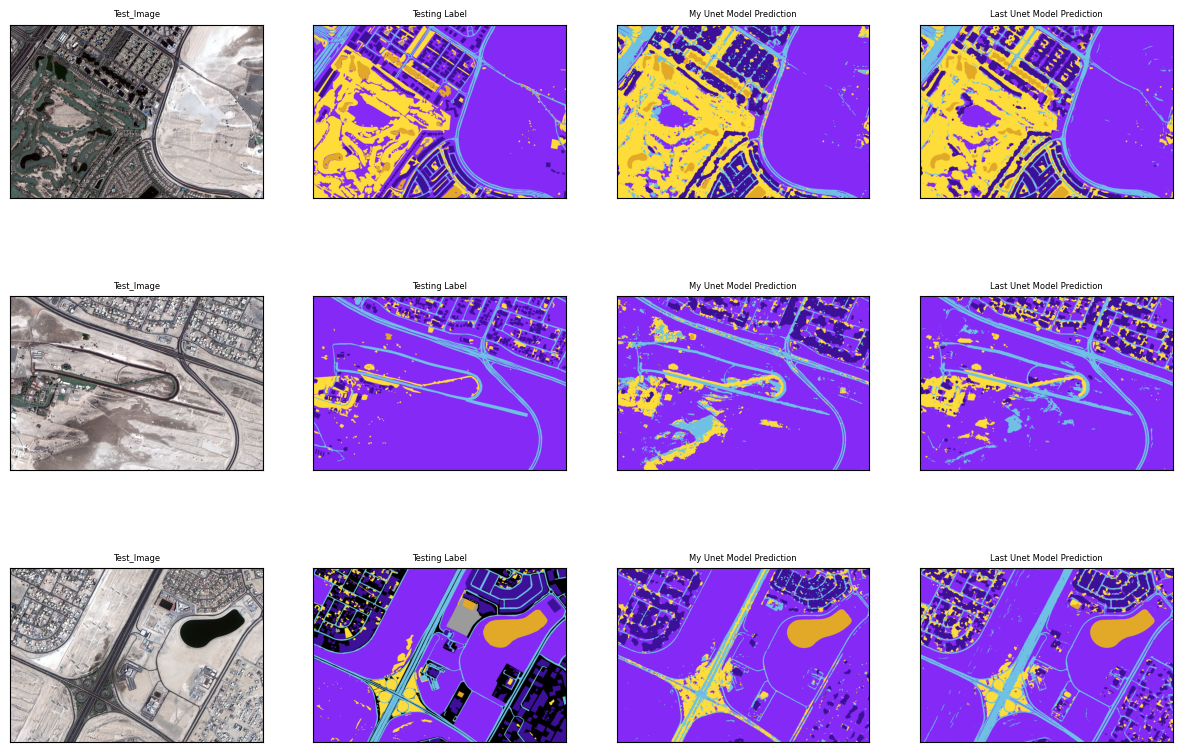

In [80]:
fig, axis = plt.subplots(3, 4)
fig.set_figwidth(15)
fig.set_figheight(10)

for img_num in range(test_num_images):   
    
    test_image = cv2.imread(os.path.join(test_img_dir, test_img_list[img_num]), 1)
    axis[img_num][0].imshow(test_image)
    axis[img_num][0].set_title('Test_Image', fontsize = 6)
    axis[img_num][0].axes.xaxis.set_visible(False)
    axis[img_num][0].axes.yaxis.set_visible(False)

    test_mask = cv2.imread(os.path.join(test_mask_dir, test_mask_list[img_num]), 1)
    test_mask = cv2.cvtColor(test_mask, cv2.COLOR_BGR2RGB)
    axis[img_num][1].imshow(test_mask)
    axis[img_num][1].set_title("Testing Label", fontsize = 6)
    axis[img_num][1].axes.xaxis.set_visible(False)
    axis[img_num][1].axes.yaxis.set_visible(False)

    axis[img_num][2].imshow(label_to_rgb(my_unet_predictions[img_num]))
    axis[img_num][2].set_title("My Unet Model Prediction", fontsize = 6)
    axis[img_num][2].axes.xaxis.set_visible(False)
    axis[img_num][2].axes.yaxis.set_visible(False)

    axis[img_num][3].imshow(label_to_rgb(last_unet_predictions[img_num]))
    axis[img_num][3].set_title("Last Unet Model Prediction", fontsize = 6)
    axis[img_num][3].axes.xaxis.set_visible(False)
    axis[img_num][3].axes.yaxis.set_visible(False)

    
plt.show()


## Задание №3. Используйте модель с Unet-подобной архитектурой для решения задач №2 и №3 из практической работы №6

In [1]:
# Поток загрузки картинок и генерации их вариаций
from keras.preprocessing.image import ImageDataGenerator

# Вывод всех путей картинок для расчета количества батчей на эпоху
from imutils.paths import list_images

# Используемая предобученная модель
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

# Слои для проектирования своей модели
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Conv2D, UpSampling2D, Conv2DTranspose, BatchNormalization, Dropout, MaxPooling2D, concatenate
from tensorflow.keras.optimizers import Adamax

# NumPy
import numpy as np

# Операции над картинками
import cv2

# Отображение графиков
import matplotlib.pyplot as plt
import plotly.graph_objects as go

# Нормальное отображение прогресса обучения нейронной сети без излишнего вывода
from tqdm.keras import TqdmCallback

# Проверка работоспособности GPU
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 742156246028102917
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 5717884928
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 17731000936552168074
 physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3070, pci bus id: 0000:02:00.0, compute capability: 8.6"
 xla_global_id: 416903419]

### Работа №6.2

In [86]:
# import splitfolders  # or import split_folders

# input_folder = 'data1'
# output_folder = 'dataset1'

# splitfolders.ratio(input_folder, output=output_folder, seed=42, ratio=(.75, .25), group_prefix=None) # default values

Copying files: 8002 files [00:55, 143.21 files/s]


In [30]:
seed=24
batch_size=20

train_dataset_path = 'dataset1\\train'
val_dataset_path = 'dataset1\\val'

In [31]:
def preprocess_data(source, target):
    source = preprocess_input(source)
    
    source = source.astype('float32') / 255.0
    target = target.astype('float32') / 255.0
    
    return (source, target)

In [32]:
def trainGenerator(train_path):   
    train_img_path = train_path + '\\' + 'train'
    train_target_path = train_path + '\\' + 'target'
    
    img_data_gen_args = dict(horizontal_flip=True,
                      vertical_flip=True)
    
    image_datagen = ImageDataGenerator(**img_data_gen_args)
    image_generator = image_datagen.flow_from_directory(
        train_img_path,
        color_mode='rgb',
        target_size=(224, 224),
        class_mode = None,
        batch_size = batch_size,
        seed = seed)
    
    target_datagen = ImageDataGenerator(**img_data_gen_args)
    target_generator = target_datagen.flow_from_directory(
        train_target_path,
        color_mode='rgb',
        target_size=(224, 224),
        class_mode = None,
        batch_size = batch_size,
        seed = seed)
    
    train_generator = zip(image_generator, target_generator)
    
    for (img, target) in train_generator:
        processed_img, processed_target = preprocess_data(img, target)
        yield (processed_img, processed_target)

In [33]:
train_gen = trainGenerator(train_dataset_path)
val_gen = trainGenerator(val_dataset_path)

train_steps_count = len(list(list_images(train_dataset_path + '\\' + 'train'))) // batch_size
val_steps_count = len(list(list_images(val_dataset_path + '\\' + 'train'))) // batch_size
print(f'Train steps per epoch: {train_steps_count}')
print(f'Val steps per epoch: {val_steps_count}')

Train steps per epoch: 150
Val steps per epoch: 50


In [110]:
input_layer = Input((224, 224, 3), name = 'input_1')

conv_1        = Conv2D(filters = 16,  kernel_size = (3, 3), padding = 'same', activation = 'relu', name = 'conv_1')(input_layer)
batchnorm_1   = BatchNormalization(name = 'batchnorm_1')(conv_1)
dropout_1     = Dropout(0.1, name = 'dropout_1')(batchnorm_1)
conv_2        = Conv2D(filters = 16,  kernel_size = (3, 3), padding = 'same', activation = 'relu', name = 'conv_2')(dropout_1)
batchnorm_2   = BatchNormalization(name = 'batchnorm_2')(conv_2)
dropout_2     = Dropout(0.1, name = 'dropout_2')(batchnorm_2)
pool_1        = MaxPooling2D(pool_size = (2, 2), name = 'pool_1')(dropout_2)
conv_3        = Conv2D(filters = 32,  kernel_size = (3, 3), padding = 'same', activation = 'relu', name = 'conv_3')(pool_1)
batchnorm_3   = BatchNormalization(name = 'batchnorm_3')(conv_3)
dropout_3     = Dropout(0.1, name = 'dropout_3')(batchnorm_3)
conv_4        = Conv2D(filters = 32,  kernel_size = (3, 3), padding = 'same', activation = 'relu', name = 'conv_4')(dropout_3)
batchnorm_4   = BatchNormalization(name = 'batchnorm_4')(conv_4)
dropout_4     = Dropout(0.1, name = 'dropout_4')(batchnorm_4)
pool_2        = MaxPooling2D(pool_size = (2, 2), name = 'pool_2')(dropout_4)
conv_5        = Conv2D(filters = 64,  kernel_size = (3, 3), padding = 'same', activation = 'relu', name = 'conv_5')(pool_2)
batchnorm_5   = BatchNormalization(name = 'batchnorm_5')(conv_5)
dropout_5     = Dropout(0.1, name = 'dropout_5')(batchnorm_5)
conv_6        = Conv2D(filters = 64,  kernel_size = (3, 3), padding = 'same', activation = 'relu', name = 'conv_6')(dropout_5)
batchnorm_6   = BatchNormalization(name = 'batchnorm_6')(conv_6)
dropout_6     = Dropout(0.1, name = 'dropout_6')(batchnorm_6)
pool_3        = MaxPooling2D(pool_size = (2, 2), name = 'pool_3')(dropout_6)
conv_7        = Conv2D(filters = 128, kernel_size = (3, 3), padding = 'same', activation = 'relu', name = 'conv_7')(pool_3)
batchnorm_7   = BatchNormalization(name = 'batchnorm_7')(conv_7)
dropout_7     = Dropout(0.1, name = 'dropout_7')(batchnorm_7)
conv_8        = Conv2D(filters = 128, kernel_size = (3, 3), padding = 'same', activation = 'relu', name = 'conv_8')(dropout_7)
batchnorm_8   = BatchNormalization(name = 'batchnorm_8')(conv_8)
dropout_8     = Dropout(0.1, name = 'dropout_8')(batchnorm_8)
pool_4        = MaxPooling2D(pool_size = (2, 2), name = 'pool_4')(dropout_8)
conv_9        = Conv2D(filters = 256, kernel_size = (3, 3), padding = 'same', activation = 'relu', name = 'conv_9')(pool_4)
batchnorm_9   = BatchNormalization(name = 'batchnorm_9')(conv_9)
dropout_9     = Dropout(0.1, name  ='dropout_9')(batchnorm_9)
conv_10       = Conv2D(filters = 256, kernel_size = (3, 3), padding = 'same', activation = 'relu', name = 'conv_10')(dropout_9)
batchnorm_10  = BatchNormalization(name = 'batchnorm_10')(conv_10)
dropout_10    = Dropout(0.1, name = 'dropout_10')(batchnorm_10)

upconv_1      = Conv2DTranspose(filters = 128, kernel_size = (2, 2), strides = (2, 2), name = 'upconv_1')(dropout_10)
conv_11       = Conv2D(filters = 128, kernel_size = (3, 3), padding = 'same', activation = 'relu', name = 'conv_11')(upconv_1)
concat_1      = concatenate([conv_11, conv_8])
batchnorm_11  = BatchNormalization(name = 'batchnorm_11')(concat_1)
dropout_11    = Dropout(0.1, name = 'dropout_11')(batchnorm_11)
upconv_2      = Conv2DTranspose(filters = 64, kernel_size = (2, 2), strides = (2, 2), name = 'upconv_2')(dropout_11)
conv_12       = Conv2D(filters = 64, kernel_size = (3, 3), padding = 'same', activation = 'relu', name = 'conv_12')(upconv_2)
concat_2      = concatenate([conv_12, conv_6])
batchnorm_12  = BatchNormalization(name = 'batchnorm_12')(concat_2)
dropout_12    = Dropout(0.1, name = 'dropout_12')(batchnorm_12)
upconv_3      = Conv2DTranspose(filters = 32, kernel_size = (2, 2), strides = (2, 2), name = 'upconv_3')(dropout_12)
conv_13       = Conv2D(filters = 32, kernel_size = (3, 3), padding = 'same', activation = 'relu', name = 'conv_13')(upconv_3)
concat_3      = concatenate([conv_13, conv_4])
batchnorm_13  = BatchNormalization(name = 'batchnorm_13')(concat_3)
dropout_13    = Dropout(0.1, name = 'dropout_13')(batchnorm_13)
upconv_4      = Conv2DTranspose(filters = 16, kernel_size = (2, 2), strides = (2, 2), name = 'upconv_4')(dropout_13)
conv_14       = Conv2D(filters = 16, kernel_size = (3, 3), padding = 'same', name = 'conv_14')(upconv_4)
concat_4      = concatenate([conv_14, conv_2])
conv_15       = Conv2D(filters = 3, kernel_size = (1, 1), activation = 'sigmoid', name = 'conv_15')(concat_4)

my_unet_model_1 = Model(inputs = input_layer, outputs = conv_15, name = 'model')
my_unet_model_1.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

In [111]:
my_unet_model_1.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv_1 (Conv2D)                (None, 224, 224, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batchnorm_1 (BatchNormalizatio  (None, 224, 224, 16  64         ['conv_1[0][0]']                 
 n)                             )                                                             

                                                                                                  
 dropout_9 (Dropout)            (None, 14, 14, 256)  0           ['batchnorm_9[0][0]']            
                                                                                                  
 conv_10 (Conv2D)               (None, 14, 14, 256)  590080      ['dropout_9[0][0]']              
                                                                                                  
 batchnorm_10 (BatchNormalizati  (None, 14, 14, 256)  1024       ['conv_10[0][0]']                
 on)                                                                                              
                                                                                                  
 dropout_10 (Dropout)           (None, 14, 14, 256)  0           ['batchnorm_10[0][0]']           
                                                                                                  
 upconv_1 

In [112]:
from tqdm.keras import TqdmCallback
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, CSVLogger, BackupAndRestore

# Создать директорию для бэкапов модели
backup_dir = 'tmp/backup'
Path(backup_dir).mkdir(parents=True, exist_ok=True)

my_callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, verbose=1),
    #ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=0, min_lr=0.0001),
    BackupAndRestore(backup_dir),
    CSVLogger("myunet_1_categorical_focal_dice_loss_history.csv", append=True),
    TqdmCallback(verbose=1),
]

my_unet_model_1_history = my_unet_model_1.fit(
    train_gen,
    steps_per_epoch=train_steps_count,
    epochs=10,
    verbose=0, 
    validation_steps=val_steps_count,
    validation_data=val_gen,
    callbacks=my_callbacks
)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

In [12]:
def print_stats(history_path, name):
    history = pd.read_csv(history_path)
    fig, axs = plt.subplots(2, 1, sharex=True)
    
    fig.set_figwidth(15)
    fig.set_figheight(15)
    fig.suptitle(name)
    plt.xlabel('Epochs', fontsize=10)
    
    axs[0].set_title("Training and validation loss")
    axs[0].plot(history['loss'])
    axs[0].plot(history['val_loss'])
    axs[0].set_ylabel('Loss')
    axs[0].legend(['Training loss', 'Validation loss'], loc="upper right")

    axs[1].set_title("Training and validation accuracy")
    axs[1].plot(history['accuracy'])
    axs[1].plot(history['val_accuracy'])
    axs[1].set_ylabel('Accuracy')
    axs[1].legend(['Training accuracy', 'Validation accuracy'], loc="lower right")

    fig.subplots_adjust(bottom=0.1, top=0.95)


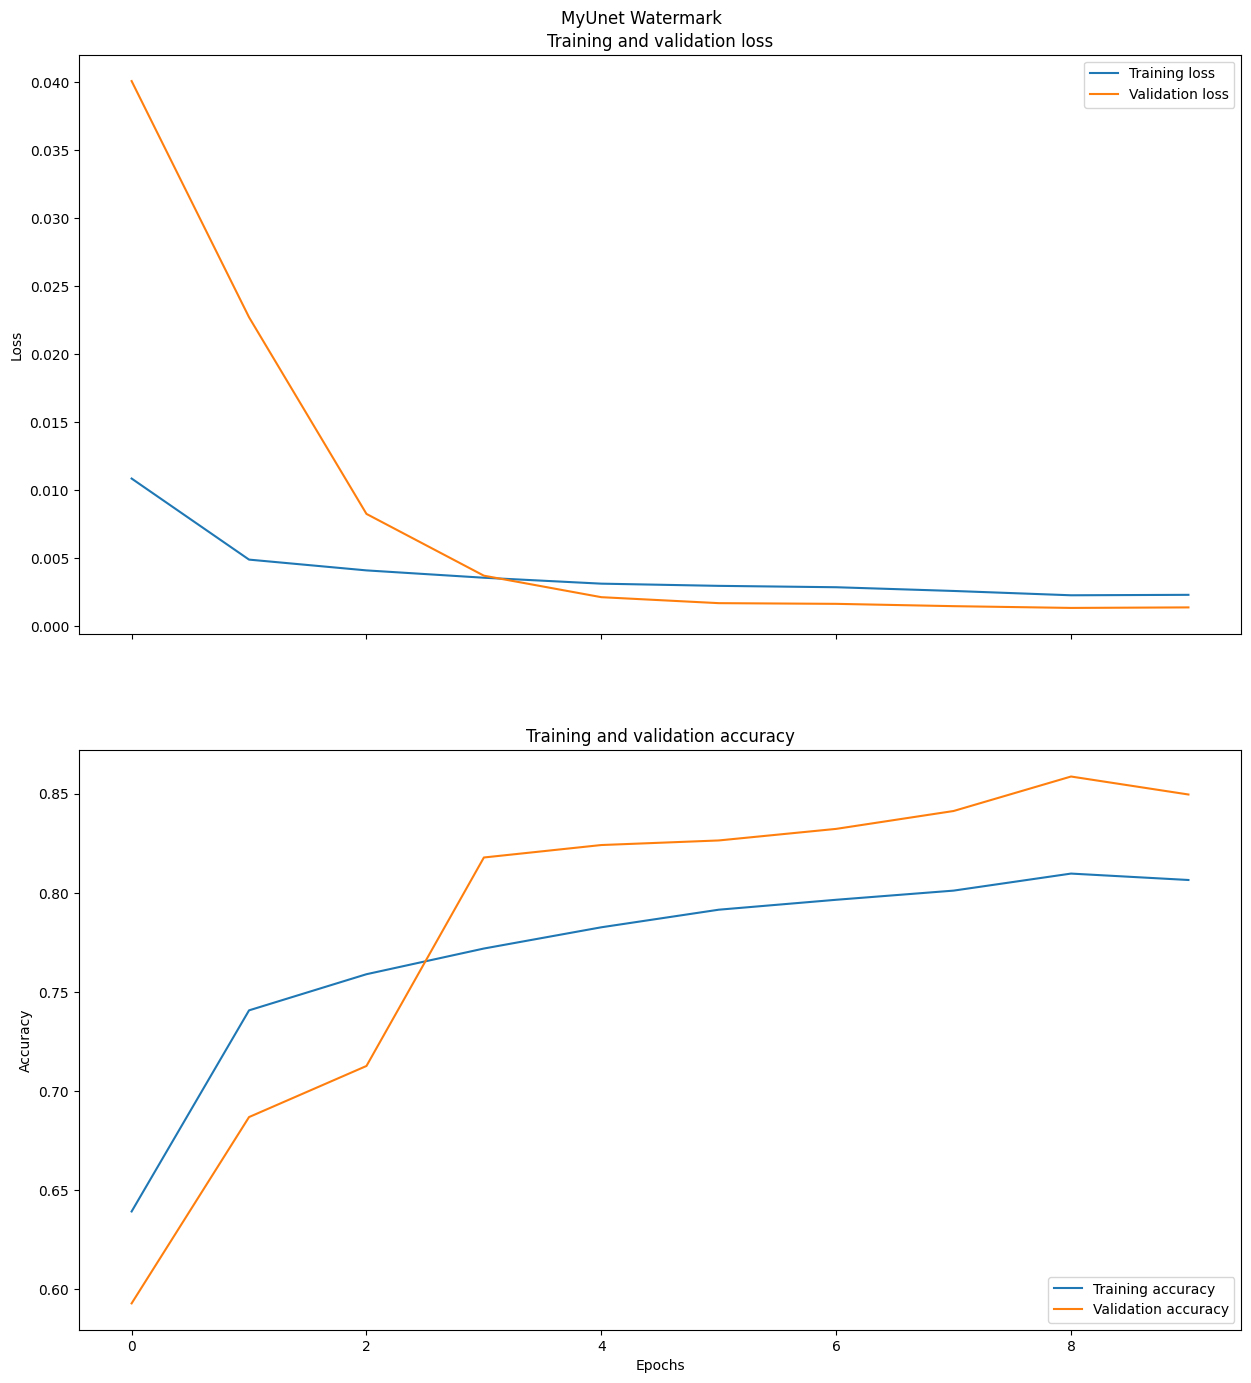

In [153]:
print_stats('myunet_1_categorical_focal_dice_loss_history.csv', 'MyUnet Watermark')

In [118]:
my_unet_model_1.save('myunet_1_categorical_focal_dice_loss.h5', save_format='h5')

### Работа №6.3

In [131]:
# import splitfolders  # or import split_folders

# input_folder = 'data2'
# output_folder = 'dataset2'

# splitfolders.ratio(input_folder, output=output_folder, seed=42, ratio=(.75, .25), group_prefix=None) # default values

Copying files: 3998 files [00:31, 125.13 files/s]


In [2]:
seed=24
batch_size=20

train_dataset_path = 'dataset2\\train'
val_dataset_path = 'dataset2\\val'

In [3]:
def preprocess_data(source, target):
    source = preprocess_input(source)
    
    source = source.astype('float32') / 255.0
    target = target.astype('float32') / 255.0
    
    return (source, target)

In [4]:
def trainGenerator(train_path):   
    train_img_path = train_path + '\\' + 'train'
    train_target_path = train_path + '\\' + 'target'
    
    img_data_gen_args = dict(horizontal_flip=True,
                      vertical_flip=True)
    
    image_datagen = ImageDataGenerator(**img_data_gen_args)
    image_generator = image_datagen.flow_from_directory(
        train_img_path,
        color_mode='rgb',
        target_size=(256, 256),
        class_mode = None,
        batch_size = batch_size,
        seed = seed)
    
    target_datagen = ImageDataGenerator(**img_data_gen_args)
    target_generator = target_datagen.flow_from_directory(
        train_target_path,
        color_mode='rgb',
        target_size=(512, 512),
        class_mode = None,
        batch_size = batch_size,
        seed = seed)
    
    train_generator = zip(image_generator, target_generator)
    
    for (img, target) in train_generator:
        processed_img, processed_target = preprocess_data(img, target)
        yield (processed_img, processed_target)

In [5]:
train_gen = trainGenerator(train_dataset_path)
val_gen = trainGenerator(val_dataset_path)

train_steps_count = len(list(list_images(train_dataset_path + '\\' + 'train'))) // batch_size
val_steps_count = len(list(list_images(val_dataset_path + '\\' + 'train'))) // batch_size
print(f'Train steps per epoch: {train_steps_count}')
print(f'Val steps per epoch: {val_steps_count}')

Train steps per epoch: 74
Val steps per epoch: 25


In [6]:
input_layer = Input((256, 256, 3), name = 'input_1')

conv_1        = Conv2D(filters = 16,  kernel_size = (3, 3), padding = 'same', activation = 'relu', name = 'conv_1')(input_layer)
batchnorm_1   = BatchNormalization(name = 'batchnorm_1')(conv_1)
dropout_1     = Dropout(0.1, name = 'dropout_1')(batchnorm_1)
conv_2        = Conv2D(filters = 16,  kernel_size = (3, 3), padding = 'same', activation = 'relu', name = 'conv_2')(dropout_1)
batchnorm_2   = BatchNormalization(name = 'batchnorm_2')(conv_2)
dropout_2     = Dropout(0.1, name = 'dropout_2')(batchnorm_2)
pool_1        = MaxPooling2D(pool_size = (2, 2), name = 'pool_1')(dropout_2)
conv_3        = Conv2D(filters = 32,  kernel_size = (3, 3), padding = 'same', activation = 'relu', name = 'conv_3')(pool_1)
batchnorm_3   = BatchNormalization(name = 'batchnorm_3')(conv_3)
dropout_3     = Dropout(0.1, name = 'dropout_3')(batchnorm_3)
conv_4        = Conv2D(filters = 32,  kernel_size = (3, 3), padding = 'same', activation = 'relu', name = 'conv_4')(dropout_3)
batchnorm_4   = BatchNormalization(name = 'batchnorm_4')(conv_4)
dropout_4     = Dropout(0.1, name = 'dropout_4')(batchnorm_4)
pool_2        = MaxPooling2D(pool_size = (2, 2), name = 'pool_2')(dropout_4)
conv_5        = Conv2D(filters = 64,  kernel_size = (3, 3), padding = 'same', activation = 'relu', name = 'conv_5')(pool_2)
batchnorm_5   = BatchNormalization(name = 'batchnorm_5')(conv_5)
dropout_5     = Dropout(0.1, name = 'dropout_5')(batchnorm_5)
conv_6        = Conv2D(filters = 64,  kernel_size = (3, 3), padding = 'same', activation = 'relu', name = 'conv_6')(dropout_5)
batchnorm_6   = BatchNormalization(name = 'batchnorm_6')(conv_6)
dropout_6     = Dropout(0.1, name = 'dropout_6')(batchnorm_6)
pool_3        = MaxPooling2D(pool_size = (2, 2), name = 'pool_3')(dropout_6)
conv_7        = Conv2D(filters = 128, kernel_size = (3, 3), padding = 'same', activation = 'relu', name = 'conv_7')(pool_3)
batchnorm_7   = BatchNormalization(name = 'batchnorm_7')(conv_7)
dropout_7     = Dropout(0.1, name = 'dropout_7')(batchnorm_7)
conv_8        = Conv2D(filters = 128, kernel_size = (3, 3), padding = 'same', activation = 'relu', name = 'conv_8')(dropout_7)
batchnorm_8   = BatchNormalization(name = 'batchnorm_8')(conv_8)
dropout_8     = Dropout(0.1, name = 'dropout_8')(batchnorm_8)
pool_4        = MaxPooling2D(pool_size = (2, 2), name = 'pool_4')(dropout_8)
conv_9        = Conv2D(filters = 256, kernel_size = (3, 3), padding = 'same', activation = 'relu', name = 'conv_9')(pool_4)
batchnorm_9   = BatchNormalization(name = 'batchnorm_9')(conv_9)
dropout_9     = Dropout(0.1, name  ='dropout_9')(batchnorm_9)
conv_10       = Conv2D(filters = 256, kernel_size = (3, 3), padding = 'same', activation = 'relu', name = 'conv_10')(dropout_9)
batchnorm_10  = BatchNormalization(name = 'batchnorm_10')(conv_10)
dropout_10    = Dropout(0.1, name = 'dropout_10')(batchnorm_10)

upconv_1      = Conv2DTranspose(filters = 128, kernel_size = (2, 2), strides = (2, 2), name = 'upconv_1')(dropout_10)
conv_11       = Conv2D(filters = 128, kernel_size = (3, 3), padding = 'same', activation = 'relu', name = 'conv_11')(upconv_1)
concat_1      = concatenate([conv_11, conv_8])
batchnorm_11  = BatchNormalization(name = 'batchnorm_11')(concat_1)
dropout_11    = Dropout(0.1, name = 'dropout_11')(batchnorm_11)
upconv_2      = Conv2DTranspose(filters = 64, kernel_size = (2, 2), strides = (2, 2), name = 'upconv_2')(dropout_11)
conv_12       = Conv2D(filters = 64, kernel_size = (3, 3), padding = 'same', activation = 'relu', name = 'conv_12')(upconv_2)
concat_2      = concatenate([conv_12, conv_6])
batchnorm_12  = BatchNormalization(name = 'batchnorm_12')(concat_2)
dropout_12    = Dropout(0.1, name = 'dropout_12')(batchnorm_12)
upconv_3      = Conv2DTranspose(filters = 32, kernel_size = (2, 2), strides = (2, 2), name = 'upconv_3')(dropout_12)
conv_13       = Conv2D(filters = 32, kernel_size = (3, 3), padding = 'same', activation = 'relu', name = 'conv_13')(upconv_3)
concat_3      = concatenate([conv_13, conv_4])
batchnorm_13  = BatchNormalization(name = 'batchnorm_13')(concat_3)
dropout_13    = Dropout(0.1, name = 'dropout_13')(batchnorm_13)
upconv_4      = Conv2DTranspose(filters = 16, kernel_size = (2, 2), strides = (2, 2), name = 'upconv_4')(dropout_13)
conv_14       = Conv2D(filters = 16, kernel_size = (3, 3), padding = 'same', name = 'conv_14')(upconv_4)
concat_4      = concatenate([conv_14, conv_2])
upconv_5      = Conv2DTranspose(filters = 16, kernel_size = (2, 2), strides = (2, 2), name = 'upconv_5')(concat_4)
conv_15       = Conv2D(filters = 16, kernel_size = (3, 3), padding = 'same', name = 'conv_15')(upconv_5)
conv_16       = Conv2D(filters = 3, kernel_size = (1, 1), activation = 'relu', name = 'conv_16')(conv_15)

my_unet_model_2 = Model(inputs = input_layer, outputs = conv_16, name = 'model2')
my_unet_model_2.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

In [7]:
my_unet_model_2.summary()

Model: "model2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv_1 (Conv2D)                (None, 256, 256, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batchnorm_1 (BatchNormalizatio  (None, 256, 256, 16  64         ['conv_1[0][0]']                 
 n)                             )                                                            

                                                                                                  
 dropout_9 (Dropout)            (None, 16, 16, 256)  0           ['batchnorm_9[0][0]']            
                                                                                                  
 conv_10 (Conv2D)               (None, 16, 16, 256)  590080      ['dropout_9[0][0]']              
                                                                                                  
 batchnorm_10 (BatchNormalizati  (None, 16, 16, 256)  1024       ['conv_10[0][0]']                
 on)                                                                                              
                                                                                                  
 dropout_10 (Dropout)           (None, 16, 16, 256)  0           ['batchnorm_10[0][0]']           
                                                                                                  
 upconv_1 

In [10]:
from tqdm.keras import TqdmCallback
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, CSVLogger, BackupAndRestore

# Создать директорию для бэкапов модели
backup_dir = 'tmp/backup'
Path(backup_dir).mkdir(parents=True, exist_ok=True)

my_callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, verbose=1),
    #ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=0, min_lr=0.0001),
    BackupAndRestore(backup_dir),
    CSVLogger("myunet_2_categorical_focal_dice_loss_history.csv", append=True),
    TqdmCallback(verbose=1),
]

my_unet_model_2_history = my_unet_model_2.fit(
    train_gen,
    steps_per_epoch=train_steps_count,
    epochs=10,
    verbose=0, 
    validation_steps=val_steps_count,
    validation_data=val_gen,
    callbacks=my_callbacks
)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Found 1499 images belonging to 1 classes.
Found 1499 images belonging to 1 classes.
Found 500 images belonging to 1 classes.
Found 500 images belonging to 1 classes.


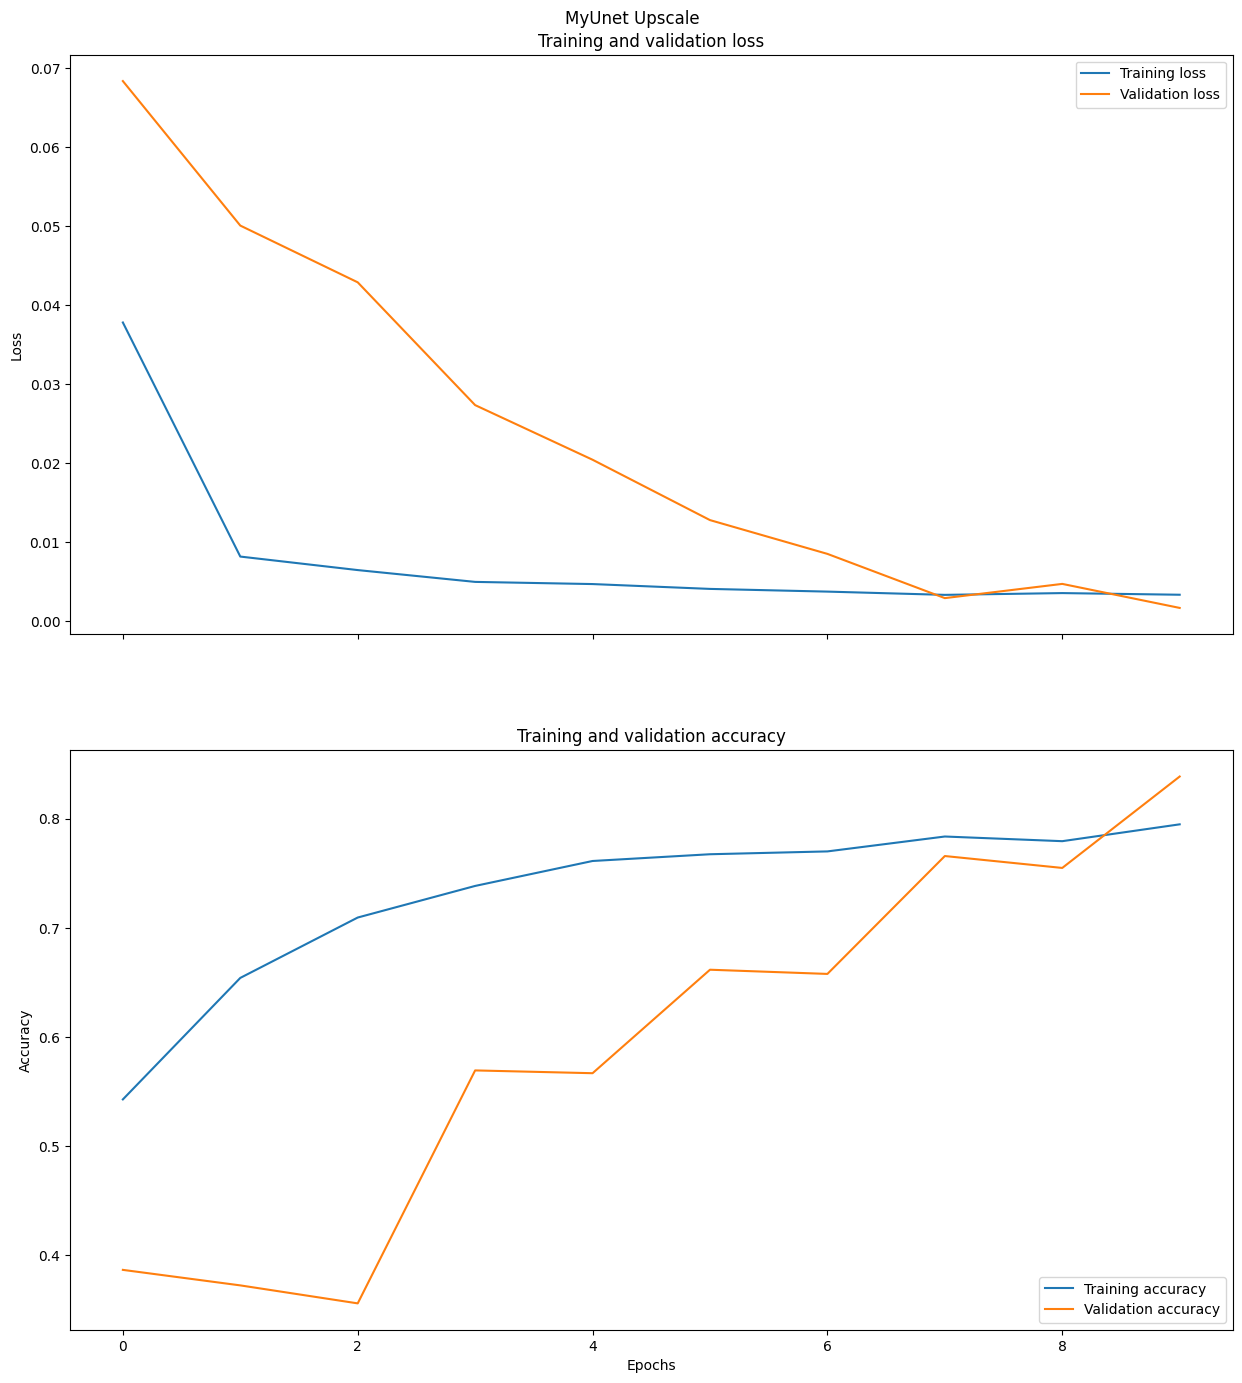

In [14]:
print_stats('myunet_2_categorical_focal_dice_loss_history.csv', 'MyUnet Upscale')

In [15]:
my_unet_model_2.save('myunet_2_categorical_focal_dice_loss.h5', save_format='h5')

### 3.1. Сравните полученные результаты

In [16]:
def predict_1(imagePath, model1, model2):
    watermark = cv2.imread(imagePath)
    watermark_prep = watermark / 255.0
    watermark_prep = np.reshape(watermark_prep, (1, 224, 224, 3))
    cleaned_img_1 = model1.predict(watermark_prep)[0]
    cleaned_img_2 = model2.predict(watermark_prep)[0]
    plt.figure()
    
    orig_plt = plt.subplot(1, 3, 1)
    orig_plt.imshow(cv2.cvtColor(watermark, cv2.COLOR_BGR2RGB))
    orig_plt.set_title("Watermark")
    orig_plt.axis("off")
    
    rgb_plt = plt.subplot(1, 3, 2)
    rgb_plt.imshow(cleaned_img_1)
    rgb_plt.set_title("Previous model")
    rgb_plt.axis("off")
    
    rgb_plt = plt.subplot(1, 3, 3)
    rgb_plt.imshow(cleaned_img_2)
    rgb_plt.set_title("New model")
    rgb_plt.axis("off")

In [18]:
from keras.models import load_model
model1   = load_model("myunet_1_categorical_focal_dice_loss.h5", compile=False)
model1_1 = load_model("watermark_vgg16_50_gen4000.h5", compile=False)

model2   = load_model("myunet_2_categorical_focal_dice_loss.h5", compile=False)
model2_1 = load_model("upscale_vgg16_4_150_gen2000.h5", compile=False)

1/1 [==============================] - 0s 30ms/step


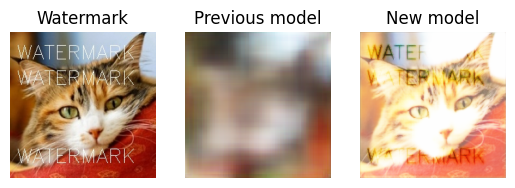

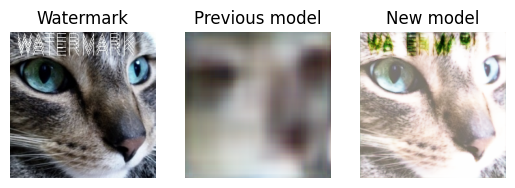

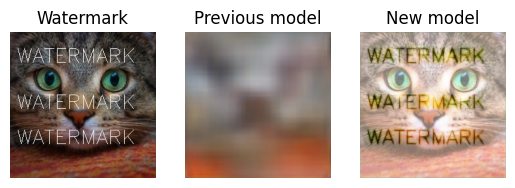

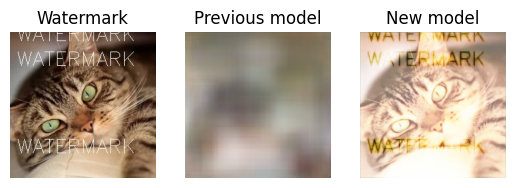

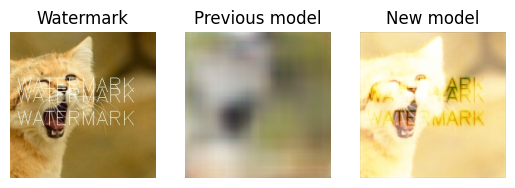

In [130]:
from imutils import paths
imagePaths = sorted(list(list_images(r"./test_images_1")))
for imagePath in imagePaths:
    predict_1(imagePath, model1_1, model1)

In [19]:
def predict2(imagePath, model1, model2):
    watermark = cv2.imread(imagePath)
    watermark_prep = watermark / 256.0
    watermark_prep = np.reshape(watermark_prep, (1, 256, 256, 3))
    cleaned_img_1 = model1.predict(watermark_prep)[0]
    cleaned_img_2 = model2.predict(watermark_prep)[0]
    plt.figure()
    
    orig_plt = plt.subplot(1, 3, 1)
    orig_plt.imshow(cv2.cvtColor(watermark, cv2.COLOR_BGR2RGB))
    orig_plt.set_title("Original")
    orig_plt.axis("off")

    orig_plt = plt.subplot(1, 3, 2)
    orig_plt.imshow(cleaned_img_1)
    orig_plt.set_title("Previous model")
    orig_plt.axis("off")
    
    orig_plt = plt.subplot(1, 3, 3)
    orig_plt.imshow(cleaned_img_2)
    orig_plt.set_title("New model")
    orig_plt.axis("off")

1/1 [==============================] - 1s 693ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 32ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 30ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 30ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 30ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


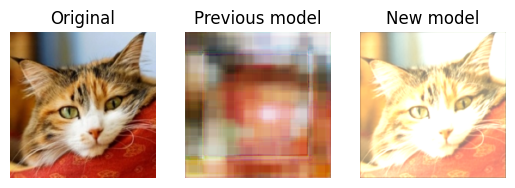

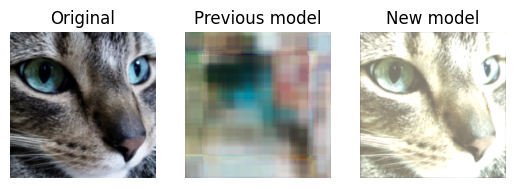

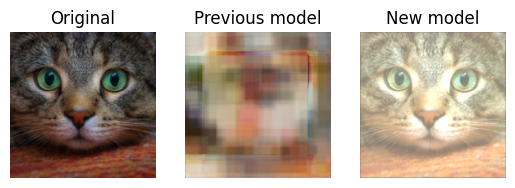

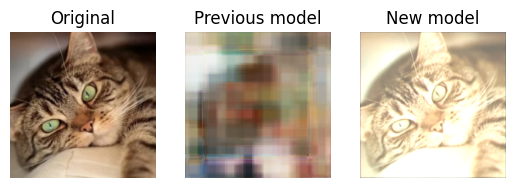

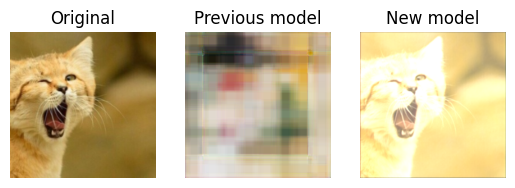

In [20]:
from imutils import paths
imagePaths = sorted(list(list_images(r"./test_images_2")))
for imagePath in imagePaths:
    predict2(imagePath, model2_1, model2)